In [51]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [52]:
import os
for dirname, _, filenames in os.walk('/Users/jeongseohyeon/Downloads/digit-recognizer/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/jeongseohyeon/Downloads/digit-recognizer/.DS_Store
/Users/jeongseohyeon/Downloads/digit-recognizer/test.csv
/Users/jeongseohyeon/Downloads/digit-recognizer/train.b2
/Users/jeongseohyeon/Downloads/digit-recognizer/SNN.ipynb
/Users/jeongseohyeon/Downloads/digit-recognizer/train.csv
/Users/jeongseohyeon/Downloads/digit-recognizer/Final_SNN.ipynb
/Users/jeongseohyeon/Downloads/digit-recognizer/sample_submission.csv


### Spiking Neural Network

In [53]:
class Brain():
    def __init__(self, n_neurons=100, n_inputs=10, n_outputs=10, n_connections=10,
                 low=-1, resting=0, threshold=1, peak=5, decay=0.5, seed=2020):
        """ Create a brain with hidden, input, and output neurons
            Args: 
            - n_neurons [int] (총 뉴런 수) : total number of neurons
            - n_inputs [int] (정보를 전달하는 pre-neuron 수) : number of neurons having input
            - n_outputs [int] (정보를 전달받는 post-neuron 수) : number of neurons having output
            - n_connections [int] (각 뉴런 당 연결되는 뉴런 수) : number of connections per neuron
            - low (뉴런의 막전위의 최솟값) : minimum potential of neuron
            - resting (초기화값) : resting potential of neuron
            - threshold (임계점): threshold potential of neuron
            - peak (활동전위의 최고점) : peak fire potential (action potential) of neuron
            - decay [float] (활동전위 감소율) : decay rate of neuron potential
            - seed [int] (랜덤 시드) : random seed for numpy
            Return: Brain object
        """
        assert n_neurons >= n_outputs + n_inputs
        assert n_neurons >= n_connections
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_connections = n_connections
        self.low = low
        self.resting = resting     
        self.threshold = threshold
        self.peak = peak
        self.decay = decay
        np.random.seed(seed)
        self.mask = self.generate_mask()
        self.initialize_weights()
        self.initialize_neurons()        

    def generate_mask(self):
        """ 
            뉴런 간의 연결 방식 설명.
            평균적으로 각 뉴런이 'n_connections' 수 만큼 연결을 가지도록 함.
            단, 뉴런이 자기자신에게 연결되는 것은 허용하지 않음
        """
        threshold = (self.n_connections + 1) / self.n_neurons
        return (np.random.rand(self.n_neurons, self.n_neurons) < threshold) & ~np.identity(self.n_neurons, dtype='bool') # 자기 자신에게는 연결되지 않도록 함.
    
    def initialize_weights(self, seed=None):
        """ 연결된 뉴런들의 가중치를 -1과 1 사이의 값으로 초기화 """
        if seed:
            np.random.seed(seed)
        self.weights = (2 * np.random.rand(self.n_neurons, self.n_neurons).astype('float32') - 1) * self.mask
    
    def initialize_neurons(self):
        self.neurons = np.ones(self.n_neurons).astype('float32') * self.resting  # 뉴런의 막전위 (potentials of the neurons)
        self.neurons_fire = np.zeros(self.n_neurons, dtype='bool')               # 뉴런이 임계치를 넘어 초기화되었는지 여부 확인 (whether the neurons fires or not)
    
    def forward_pass(self):
        """ 활동전위 누적되는 과정 설명. 특정 값만큼 증가했다가 서서히 감소하는 식으로 누적됨. """
        # compute input potential
        neurons_next = np.dot(self.weights, self.neurons_fire * self.peak) + self.decay * self.neurons
        # 뉴런이 초기화되었다면, 그 전위를 막전위의 최솟값으로 억제.(If the neuron has just fired, then suppress its potential to the lowest potential)
        neurons_next = np.where(self.neurons_fire, self.low, neurons_next)
        neurons_next = np.clip(neurons_next, a_min=self.low, a_max=None)
        # 임계값을 넘어서면 막전위가 초기화되먄 최고 수치로 놓음.(If input potential (x) is greater than threshold, then fire at peak potential, otherwise no change.
        self.neurons = neurons_next
        self.neurons_fire = self.neurons >= self.threshold
    
    def train_hebbian_one_step(self, learning_rate=0.05):
        """ 헤미안 방식의 방법으로 학습 (비지도 학습) [Train with Hebbian like method (unsupervised learning)]
            dW_ij(가중치의 변화량) = lr(학습률) * (next_fire_i(다음 활동전위) * M_ij(연결 강도) * prev_fire_j(이전 활동전위) - prev_fire_i * M_ij(이전 활동전위와 연결강도의 곱) * next_fire_j(다음 활동전위))
                  = lr * M_ij * (next_fire_i * prev_fire_j - prev_fire_i * next_fire_j)
        """
        prev_fire = self.neurons_fire
        self.forward_pass()
        next_fire = self.neurons_fire
        # dW = learning_rate * next_fire.reshape(-1, 1) * self.weights * next_fire
        dW = learning_rate * self.mask * (
            next_fire.reshape(-1, 1) * prev_fire - 1 * prev_fire.reshape(-1, 1) * next_fire
        )
        self.weights = np.clip(self.weights + dW, a_min=-1, a_max=1)
    
    def set_inputs(self, inputs):
        self.neurons[:self.n_inputs] = inputs / self.decay
    
    def get_outputs(self):
        return self.neurons[self.n_inputs : self.n_inputs + self.n_outputs]
    
    def predict(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.forward_pass()
        return self.get_outputs()
    
    def predict_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_outputs), dtype='float32')
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.get_outputs()
        return hist

    def predict_brain_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.neurons
        return hist
    
    def train_hebbian_brain_history(self, inputs, steps=10, lr=0.05, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.train_hebbian_one_step(lr)
            hist[step] = self.neurons
        return hist
    
    def train_hebbian_brain_batch(self, X, total_steps=1000, steps_per_sample=10, lr=0.05, constant_input=True):
        """ Train Hebbian brain with an array of data X """
        n_samples_train = np.ceil(total_steps / steps_per_sample).astype('int')
        total_steps = n_samples_train * steps_per_sample
        if n_samples_train > len(X):
            X = np.vstack([X] * np.ceil(n_samples_train / len(X)).astype('int'))
        X = X[:n_samples_train]
        print('training steps:', n_samples_train, 'x', steps_per_sample)
        for x in tqdm(X):
            self.set_inputs(x)
            for _ in range(steps_per_sample):
                if constant_input: 
                    self.set_inputs(x)
                self.train_hebbian_one_step(lr)

### Input Data

In [59]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
y_train = y_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
X_test = X_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]
y_test = y_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4
X_test = X_test / 4

X_train.shape, X_test.shape

((18516, 28, 28), (3089, 28, 28))

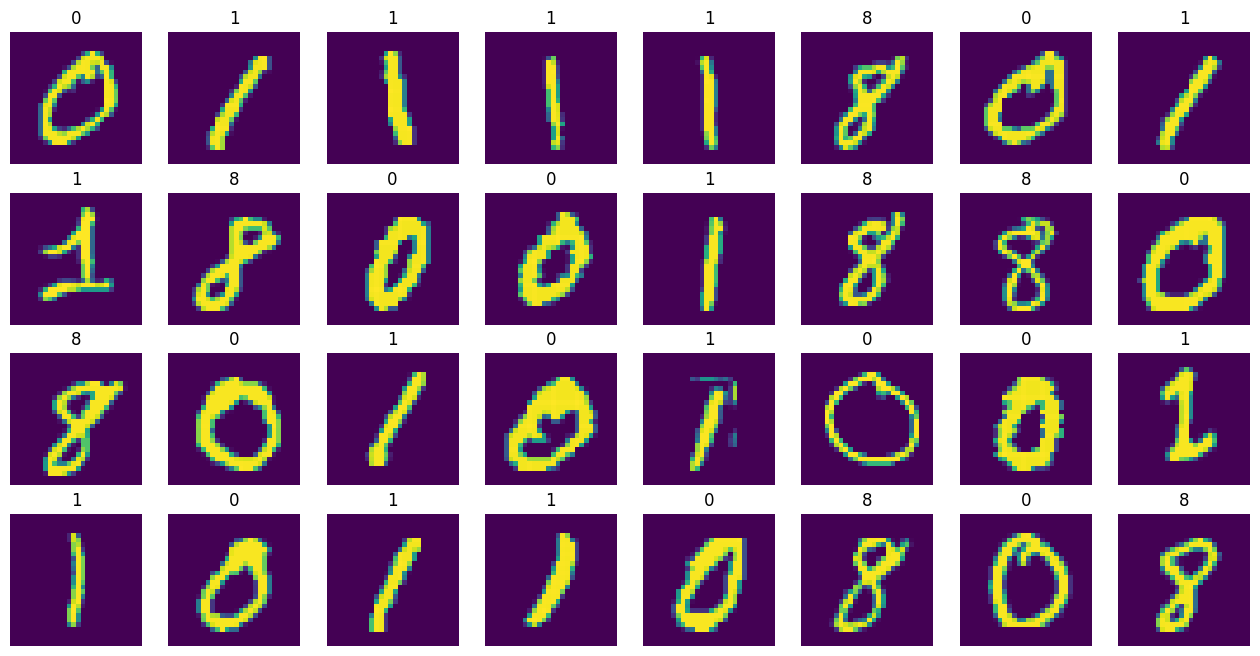

In [61]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [62]:
df_train = pd.read_csv('/Users/jeongseohyeon/Downloads/digit-recognizer/train.csv')
df_test = pd.read_csv('/Users/jeongseohyeon/Downloads/digit-recognizer/test.csv')

cols_pixels = [c for c in df_train.columns if c != 'label']

y_train = df_train['label']
x_train = df_train[cols_pixels].values
x_test = df_test[cols_pixels].values

x_train = x_train / 255
x_test = x_test / 255

print(x_train.shape, x_test.shape, y_train.shape)
print(x_train.min(), x_train.max())

(42000, 784) (28000, 784) (42000,)
0.0 1.0


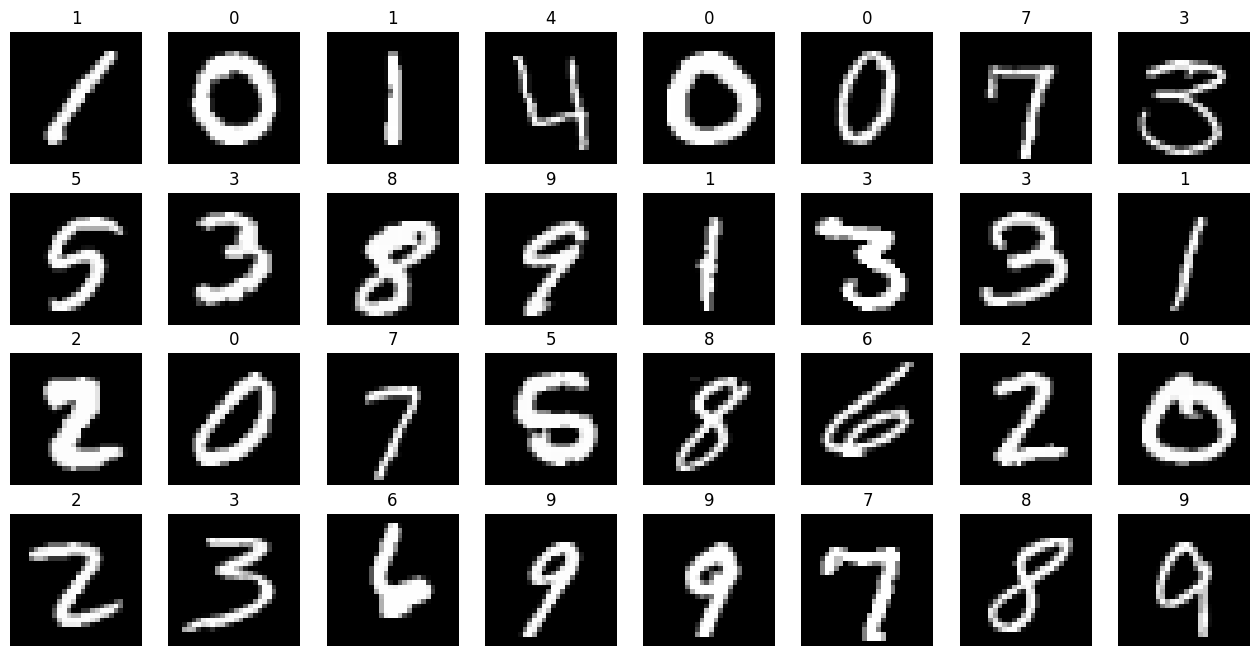

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4, 8, img + 1)
    plt.title(y_train[img])
    plt.imshow(x_train[img].reshape(28, 28), cmap='gray') # 1D에서 2D로 변환
    plt.axis('off')
plt.show()

#### Simple inputs and outputs
단순화된 원-핫 입력을 주어진 경우, 출력 패턴

In [11]:
# Create our brain
brain = Brain(n_neurons=100, n_inputs=10, n_outputs=10, n_connections=10)

In [12]:
brain.initialize_neurons()
display(brain.predict(np.array([5,]+[0]*9), 9, constant_input=False))

brain.initialize_neurons()
display(brain.predict(np.array([0]*9+[1]), 9, constant_input=False))

brain.initialize_neurons()
display(brain.predict(np.array([0]*9+[1]), 9, constant_input=True))

array([ 3.93570024, -1.        , -1.        ,  0.19184542,  5.62570852,
       -1.        ,  2.62374711, -0.30875373,  3.11819381, -1.        ])

array([ 3.58296415, -0.16528407, -1.        ,  3.97825074, -1.        ,
       -1.        , -0.5       , -1.        , -1.        , -1.        ])

array([ 3.58296415, -0.16528407, -1.        ,  3.97825074, -1.        ,
       -1.        , -0.5       , -1.        , -1.        , -1.        ])

#### Brain connections (뉴런 간 연결 상태 확인)

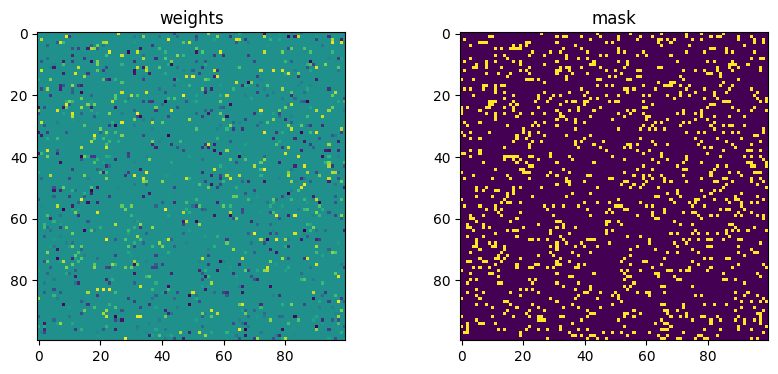

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain.mask)
plt.show()

#### Brain predict history 

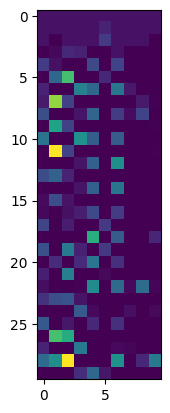

In [14]:
# History of output neuron fire (일반적인 출력 뉴런의 활동 기록 : 입력 변화 가능 )
brain.initialize_neurons()
plt.imshow(brain.predict_history(np.array([1,]+[0]*9), 30, constant_input=False)); plt.show()

**시간 단계 사이에서 활동이 번갈아 일어나는 이유** 

: 뉴런이 바로 직전 시간 단계에서 활동한 직후에는 다시 활동할 수 없기 때문.

또한, 신호가 t=0(짝수) 시간 단계에서 입력되기 때문에 뉴런이 주로 홀수 번째 시간 단계에서 활동하는 것을 관찰할 수 있음.

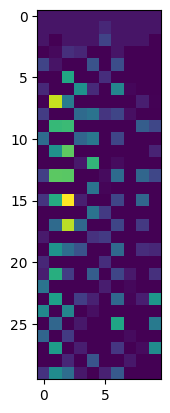

In [15]:
# History of output neuron fire with constant input (지속적인 입력에 따른 출력 뉴런 : 일정한 입력에 어떻게 달라지는지)
brain.initialize_neurons()
plt.imshow(brain.predict_history(np.array([1,]+[0]*9), 30, constant_input=True)); plt.show()

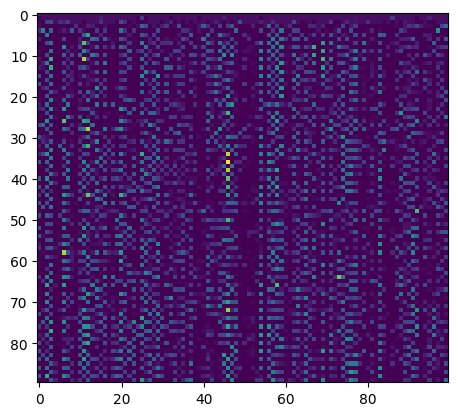

In [16]:
# History of all neurons (모든 뉴런)
brain.initialize_neurons()
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=False)); plt.show()

#### Brain response to different inputs (일정하지 않은 입력 = 일반적인 경우)

,0,1,2,3,4,5,6,7,8,9
0,3.935700,-1.000000,-1.000000,0.191845,5.625709,-1.000000,2.623747,-0.308754,3.118194,-1.000000
1,-1.000000,-1.000000,2.006653,-1.000000,7.917429,-1.000000,-1.000000,-1.000000,-1.000000,0.412379
2,0.632525,14.500953,6.588158,-1.000000,-1.000000,1.082403,6.963346,-0.256275,-1.000000,0.692933
3,2.078444,-1.000000,-1.000000,1.706902,1.035418,-0.553733,-1.000000,-1.000000,-1.000000,-1.000000
4,-1.000000,0.562623,-1.000000,4.031615,-1.000000,5.121793,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,-1.000000,4.373316,0.429114,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,1.453290,13.543540,1.952846,-1.000000,-1.000000,-1.000000,-1.000000
7,-1.000000,-1.000000,-1.000000,6.500956,10.031946,-1.000000,9.185116,-0.056334,-1.000000,-1.000000
8,0.577396,-1.000000,7.826581,2.022706,-1.000000,-1.000000,2.623747,-1.000000,4.106656,-1.000000
9,3.582964,-0.165284,-1.000000,3.978251,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,-1.000000,-1.000000,-1.000000,11.892109,-1.000000,4.845517,-1.000000,-1.000000,1.169522
1,-0.786987,5.090349,5.083811,-1.000000,-1.000000,-1.000000,0.860608,-0.740018,4.868946,-0.954339
2,-1.000000,-1.000000,-1.000000,2.363464,-1.000000,-1.000000,2.873747,-0.262885,-1.000000,-1.000000
3,4.003958,-1.000000,-1.000000,-1.000000,-1.000000,-0.270985,-1.000000,-0.746955,-1.000000,-1.000000
4,0.833462,-1.000000,3.619152,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,4.663420,7.624045,-1.000000,2.623747,-1.000000,-1.000000,-1.000000
6,-1.000000,12.739342,11.911626,-1.000000,-1.000000,-1.000000,4.845517,-1.000000,-1.000000,7.483760
7,-1.000000,-1.000000,9.918818,-1.000000,2.889665,-1.000000,-1.000000,2.302143,-0.311238,-1.000000
8,1.771033,6.991542,0.715206,-1.000000,-1.000000,0.880032,-1.000000,-1.000000,3.955470,-1.000000
9,-1.000000,-1.000000,2.916369,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,8.371576,-1.000000,4.202605,-0.000403,-1.000000,4.845517,-1.000000,2.520715,3.068185
1,-1.000000,8.586280,8.788831,-1.000000,-1.000000,-1.000000,4.845517,-1.000000,3.151656,-0.412455
2,-0.998865,-1.000000,-1.000000,3.637492,-1.000000,-1.000000,2.623747,1.433222,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,4.229607,2.114115,1.211048,-1.000000,-0.910878,-1.000000,-1.000000
4,-1.000000,-1.000000,8.005880,-1.000000,1.190555,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,0.980623,-1.000000,7.176350,3.389391,-1.000000,-1.000000,3.839598,1.616861,-1.000000,-1.000000
6,-1.000000,2.147129,4.566260,-1.000000,-1.000000,5.768284,1.762585,-1.000000,-1.000000,-1.000000
7,-1.000000,5.808799,-1.000000,-0.493324,7.312177,-1.000000,6.963346,-1.000000,-1.000000,3.150204
8,-1.000000,6.121003,10.175071,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.758936,2.695865
9,2.708582,8.091621,4.338938,-1.000000,8.670223,4.037545,-1.000000,0.266244,-1.000000,-1.000000


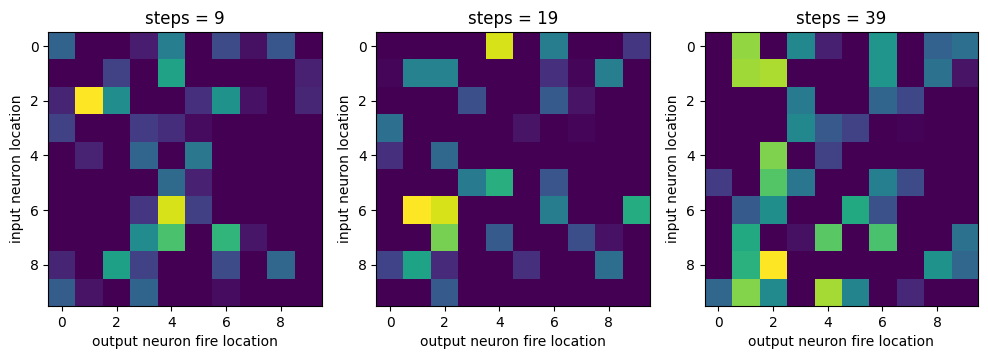

In [17]:
# non-constant inputs vs outputs at various timesteps
plt.figure(figsize=(12, 6))
steps = [9, 19, 39]
plt_subplot = 101 + 10 * len(steps)
for step in steps:
    pred = np.zeros((10, brain.n_outputs), dtype='float32')
    for i in range(10):
        brain.initialize_neurons()
        pred[i] = brain.predict(np.array([0]*i+[1]+[0]*(9 - i)), step, constant_input=False)
    display(pd.DataFrame(pred))
    plt.subplot(plt_subplot).set_title(f'steps = {step}')
    plt.imshow(pred)
    plt.ylabel('input neuron location'); plt.xlabel('output neuron fire location'); 
    plt_subplot += 1
plt.show()

#### Brain response to constant inputs (일정한 입력 주어졌을 때)

,0,1,2,3,4,5,6,7,8,9
0,2.058020,-1.000000,-1.000000,5.004179,5.625709,1.691742,2.623747,-0.308754,-1.000000,-1.000000
1,-1.000000,-1.000000,2.006653,-1.000000,7.917429,-1.000000,-1.000000,-1.000000,-1.000000,0.412379
2,0.632525,14.500953,6.588158,-1.000000,-1.000000,1.082403,6.963346,-0.256275,-1.000000,0.692933
3,5.101779,-1.000000,-1.000000,1.706902,1.911442,-0.553733,-1.000000,-1.000000,-1.000000,-1.000000
4,4.733255,-1.000000,-1.000000,3.055309,-1.000000,-1.000000,2.623747,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,0.883509,-0.500000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,-1.000000,13.543540,1.952846,-1.000000,-1.000000,-1.000000,0.945199
7,-1.000000,-1.000000,-1.000000,11.196885,2.114115,-1.000000,-0.500000,-0.641976,1.843674,-1.000000
8,2.523335,-1.000000,7.714900,-1.000000,-1.000000,-1.000000,2.623747,-1.000000,2.925541,-1.000000
9,3.582964,-0.165284,-1.000000,3.978251,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,0.269984,-1.000000,-1.000000,-1.000000,1.447384,1.952846,-1.000000,-1.000000,-1.000000,-1.000000
1,-0.087843,2.431581,-1.000000,7.461655,-1.000000,-1.000000,9.185116,-1.000000,3.172812,3.421356
2,5.162124,9.531854,5.138148,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000,5.795442
3,3.707237,-1.000000,0.237811,-1.000000,10.531544,-1.000000,-0.954954,-1.000000,-1.000000,-1.000000
4,6.348965,-1.000000,-1.000000,1.366143,10.499024,-1.000000,-1.000000,1.539956,-1.000000,-1.000000
5,2.713793,-1.000000,-1.000000,-1.000000,4.491899,6.420125,-1.000000,3.149476,-1.000000,-0.506804
6,2.038561,-1.000000,6.867652,-1.000000,-1.000000,-1.000000,-1.000000,-0.324393,1.882944,0.964085
7,-1.000000,-1.000000,-1.000000,-1.000000,9.365215,5.082246,-1.000000,-1.000000,-1.000000,-1.000000
8,4.625964,3.028768,-1.000000,-1.000000,-1.000000,3.065786,-1.000000,-1.000000,-1.000000,4.368636
9,-1.000000,2.961785,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,1.709921,8.352116,-1.000000,-1.000000,1.045776,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
1,3.030938,6.307784,3.825541,-1.000000,0.151608,1.095900,4.845517,-1.0,-1.000000,3.833556
2,2.132896,7.418875,12.487556,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.078361,2.695865
3,0.980623,-1.000000,7.075139,3.048633,-1.000000,-1.000000,-0.500000,-1.0,-1.000000,-1.000000
4,-1.000000,4.374673,11.964267,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
5,3.157620,4.375212,-1.000000,-1.000000,-1.000000,-0.850707,-1.000000,-1.0,-1.000000,-1.000000
6,3.132234,6.473301,4.709015,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,1.223505,2.695865
7,-1.000000,12.318329,8.942683,-0.455831,-1.000000,-1.000000,1.721770,-1.0,3.151656,1.388610
8,-1.000000,-1.000000,-1.000000,7.867642,-1.000000,-1.000000,2.623747,-1.0,-1.000000,-1.000000
9,0.577396,9.319843,-1.000000,3.861847,4.579530,-1.000000,2.623747,-1.0,-1.000000,-1.000000


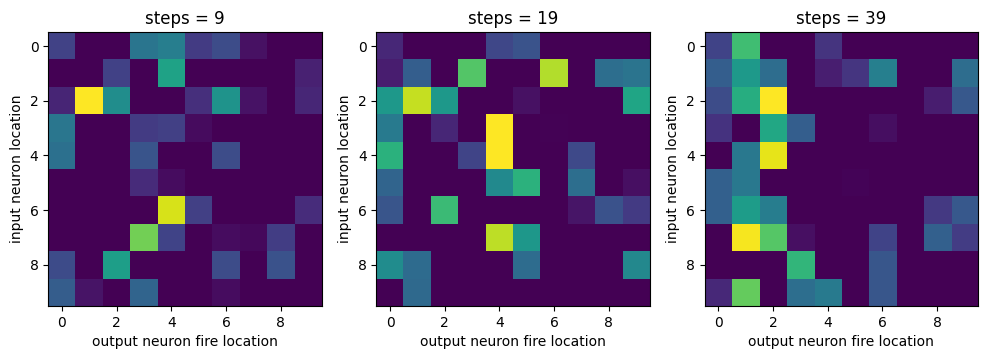

In [18]:
# constant inputs vs outputs at various timesteps
plt.figure(figsize=(12, 6))
steps = [9, 19, 39]
plt_subplot = 101 + 10 * len(steps)
for step in steps:
    pred = np.zeros((10, brain.n_outputs), dtype='float32')
    for i in range(10):
        brain.initialize_neurons()
        pred[i] = brain.predict(np.array([0]*i+[1]+[0]*(9 - i)), step, constant_input=True)
    display(pd.DataFrame(pred))
    plt.subplot(plt_subplot).set_title(f'steps = {step}')
    plt.imshow(pred)
    plt.ylabel('input neuron location'); plt.xlabel('output neuron fire location'); 
    plt_subplot += 1
plt.show()

#### constant inputs vs outputs at various timesteps (일정한 입력값 넣었을 때의 시간대에 따른 변화)

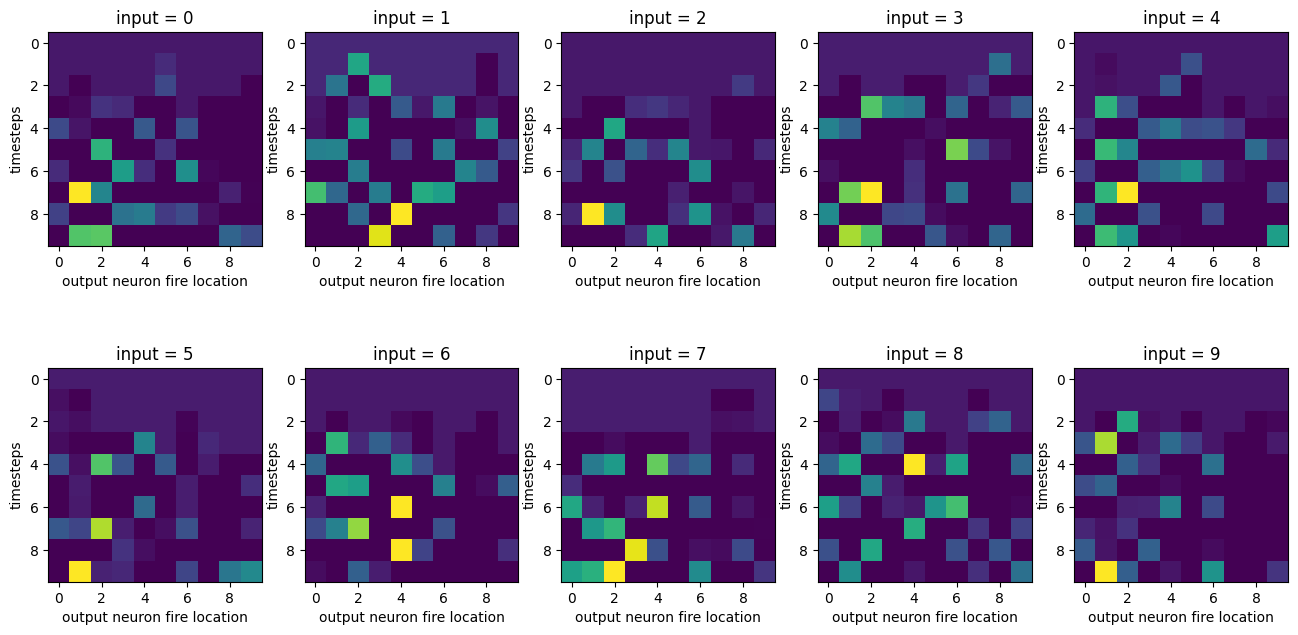

In [19]:
# constant inputs vs outputs at various timesteps
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    pred = brain.predict_history(np.array([0]*i+[1]+[0]*(9 - i)), steps=10, constant_input=True)
    #print(pred)
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(pred)
    plt.ylabel('timesteps'); plt.xlabel('output neuron fire location'); 
    plt_subplot[2] += 1
plt.show()

#### non-constant inputs vs outputs at various timesteps (일정하지 않은 입력값 넣었을 때의 시간대에 따른 변화)

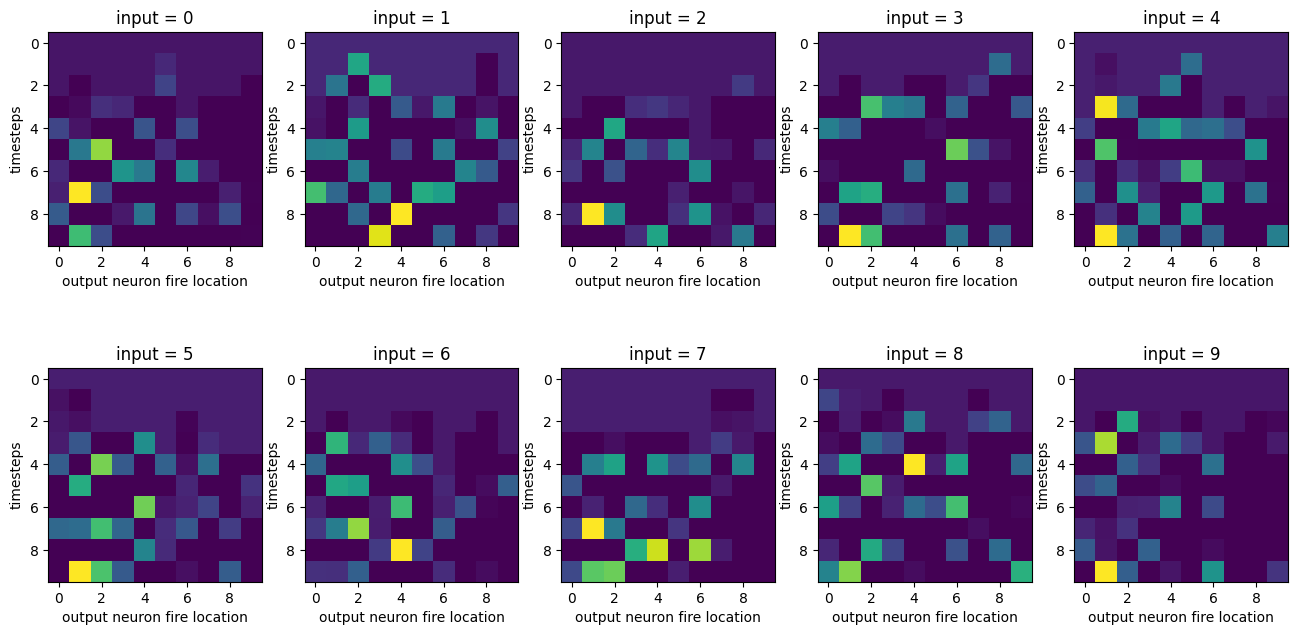

In [20]:
# non-constant inputs vs outputs at various timesteps
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    pred = brain.predict_history(np.array([0]*i+[1]+[0]*(9 - i)), steps=10, constant_input=False)
    #print(pred)
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(pred)
    plt.ylabel('timesteps'); plt.xlabel('output neuron fire location'); 
    plt_subplot[2] += 1
plt.show()

#### Train with Hebbian like theory (헤미안 방식으로 학습)

Non-constant input (일정하지 않은 입력값)


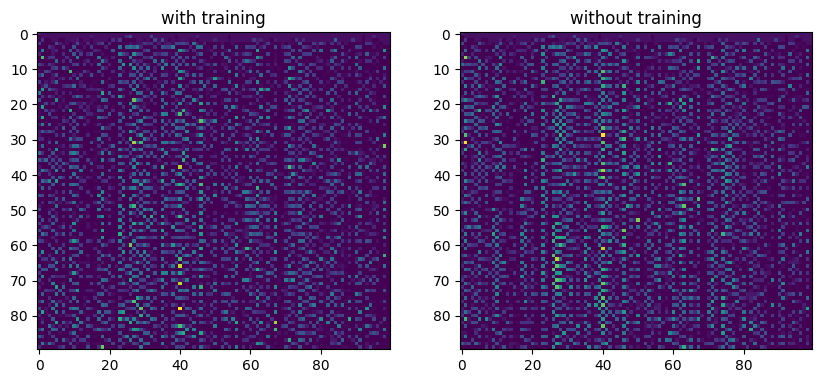

In [21]:
print('Non-constant input (일정하지 않은 입력값)')
plt.figure(figsize=(10, 5))
# with training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 1).set_title('with training')
plt.imshow(brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False))

# without training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 2).set_title('without training')
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=False))
plt.show()

Constant input (일정한 입력값)


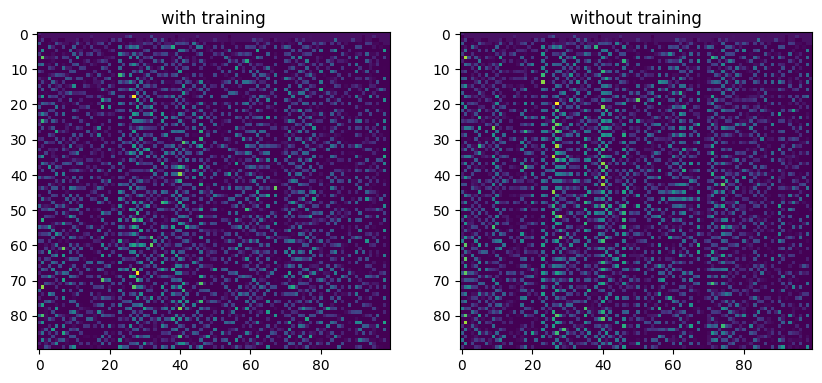

In [22]:
print('Constant input (일정한 입력값)')
plt.figure(figsize=(10, 5))
# with training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 1).set_title('with training')
plt.imshow(brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True))

# without training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 2).set_title('without training')
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=True))
plt.show()

#### 일정한 입력값을 학습했을때의 가중치 분포

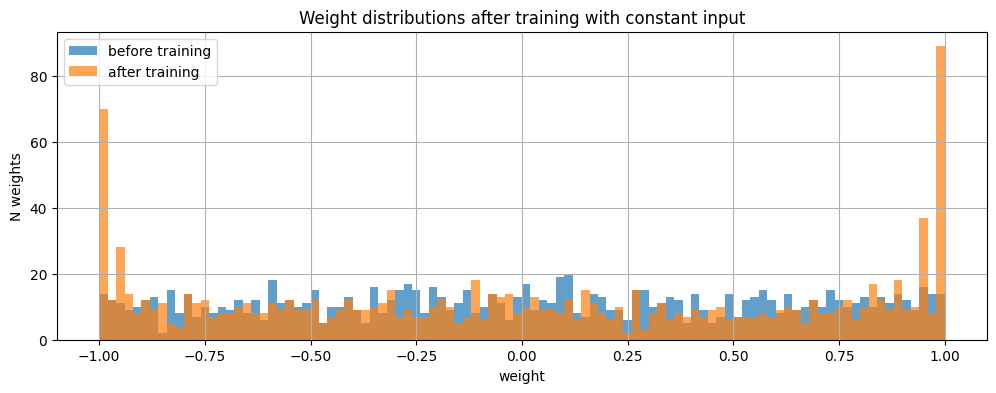

In [24]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions after training with constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='before training', alpha=0.7)
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

#### 일정하지 않은 입력값을 학습했을때의 가중치 분포

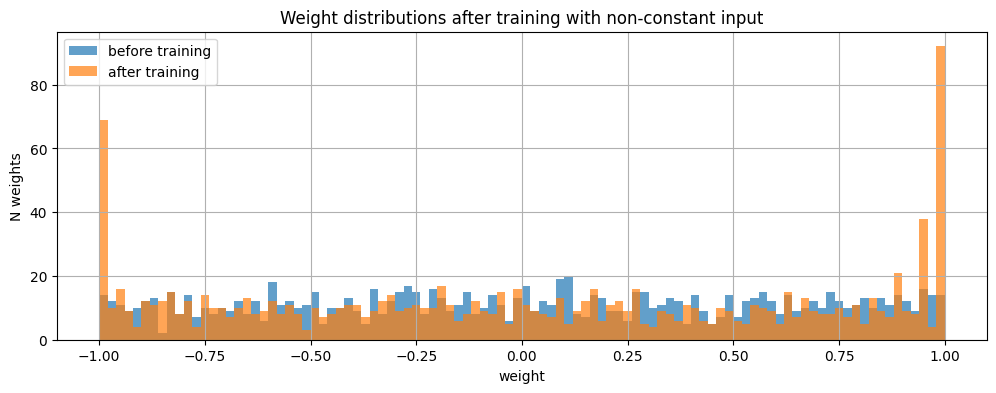

In [25]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions after training with non-constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='before training', alpha=0.7)
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

#### 일정한 입력값을 학습했을 때의 가중치 변화

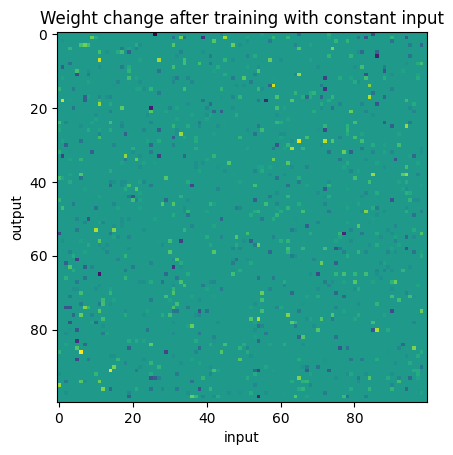

In [26]:
# Weights change
# plt.figure(figsize=(12, 4))
plt.title('Weight change after training with constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
W_before = brain.weights
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True)
dW = brain.weights - W_before
plt.imshow(dW)
plt.xlabel('input'); plt.ylabel('output')
plt.show()

#### 일정하지 않은 입력값을 학습했을 때의 가중치 변화

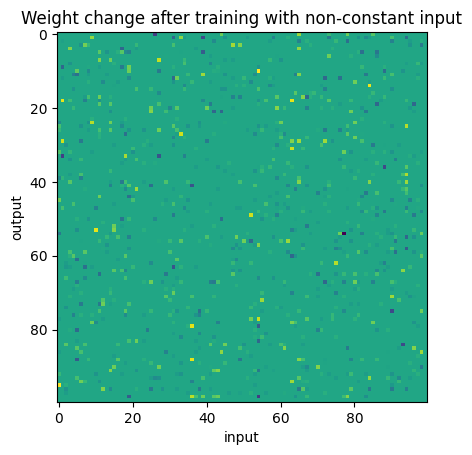

In [27]:
# Weights change
# plt.figure(figsize=(12, 4))
plt.title('Weight change after training with non-constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
W_before = brain.weights
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
dW = brain.weights - W_before
plt.imshow(dW)
plt.xlabel('input'); plt.ylabel('output')
plt.show()

#### 일정한 입력값을 학습했을 때의 가중치 변화의 시간대에 따른 변환

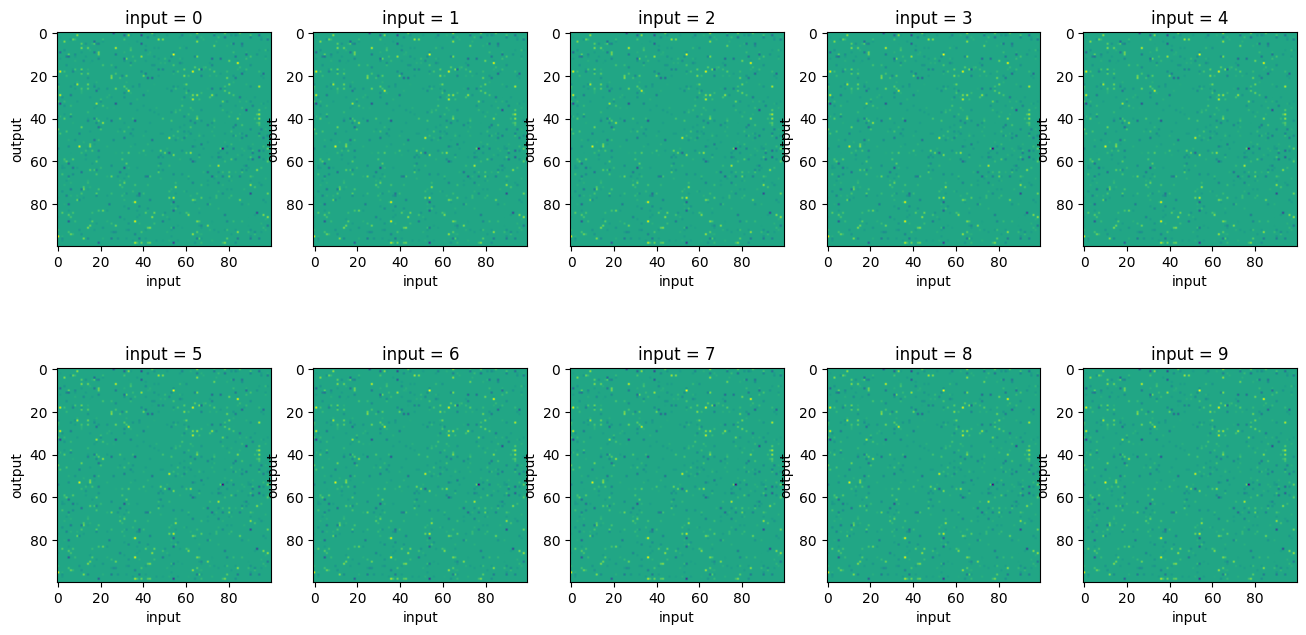

In [29]:
# weight change for various constant inputs
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    brain.initialize_weights(2030)
    W_before = brain.weights
    brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
    dW = brain.weights - W_before
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(dW)
    plt.ylabel('output'); plt.xlabel('input'); 
    plt_subplot[2] += 1
plt.show()

입력값이 일정하든 일정하지 않든 가중치 변화에 큰 영향을 주지 않는 것으로 보임

#### On real image (실제 데이터 사용)

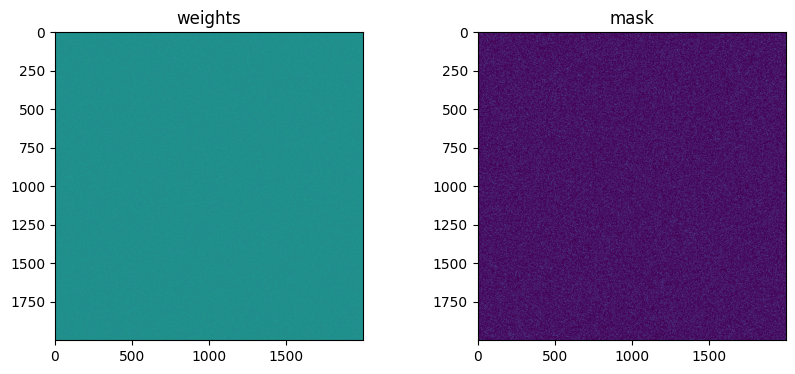

In [30]:
# Create our brain
brain_mnist = Brain(n_neurons=2000, n_inputs=784, n_outputs=10, n_connections=100)

plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain_mnist.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain_mnist.mask)
plt.show()

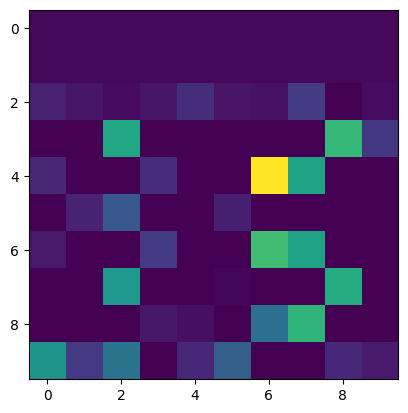

In [64]:
plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

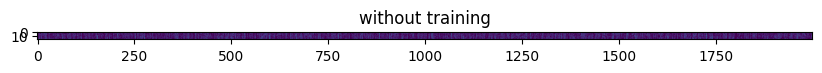

In [65]:
# before training
plt.figure(figsize=(10, 5))
brain_mnist.initialize_neurons()
brain_mnist.initialize_weights(2030)
plt.title('without training')
plt.imshow(brain_mnist.predict_brain_history(x_train[0], 20, constant_input=True))
plt.show()

weights_before = brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)]

In [66]:
%%time
# training
brain_mnist.train_hebbian_brain_batch(x_train, 1000)

training steps: 100 x 10


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2min 23s, sys: 2min 27s, total: 4min 50s
Wall time: 26.8 s


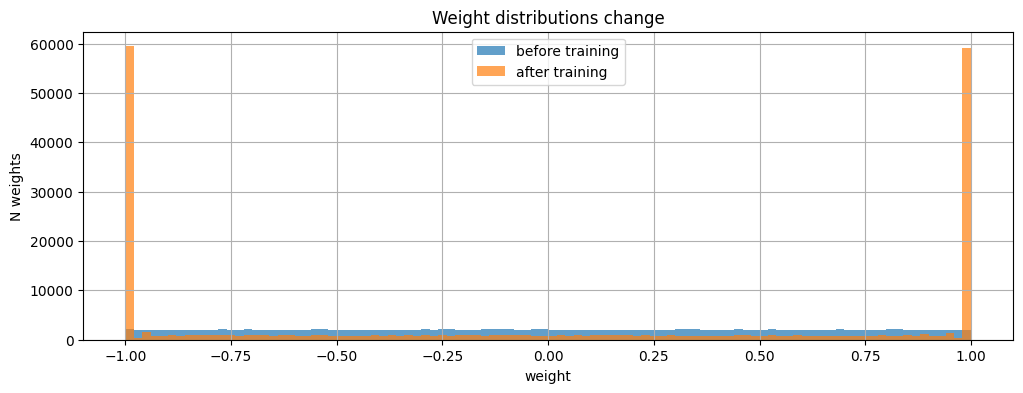

In [67]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions change')
plt.hist(weights_before, bins=plt_bins, label='before training', alpha=0.7)
plt.hist(brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

#### input에 따른 출력 예측 (입력이 일정할 때)

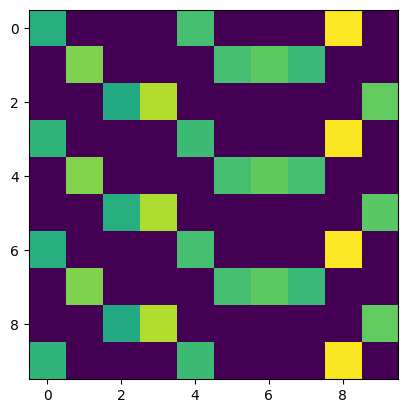

In [68]:
plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

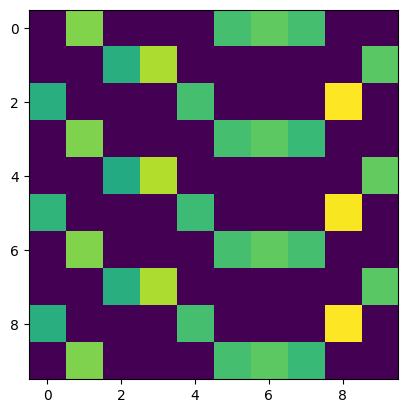

In [69]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=True)); plt.show()

#### input에 따른 출력 예측 (입력이 일정하지 않을 때)

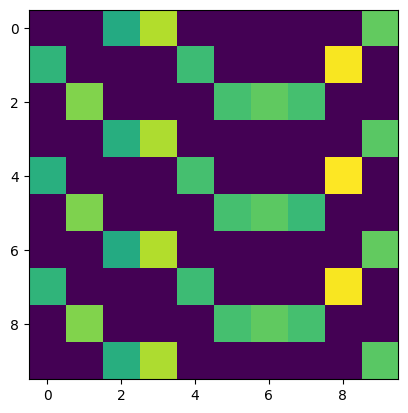

In [70]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=False)); plt.show()

#### Spiking Neural Network (새로운 모델)

''' ''' 또는 """ """로 감싸진 문자열은 멀티라인 문자열을 정의하는데 사용됨. (문자열을 변수에 할당할 때 사용) 

In [71]:
n_input = 28*28 # input layer
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():
    
    def __init__(self, debug=False):
        app = {}
                
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
        
        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV
        
        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')
        
        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')
        
        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M') 
        
        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        self.net = Network(app.values())
        self.net.run(0*second)
        
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X, epoch=1):        
        self.net['S1'].lr = 1 # stdp on
        
        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)
        
    def evaluate(self, X):       
        self.net['S1'].lr = 0  # stdp off
        
        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)
            
            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)
            
            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))
            
            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            
            self.net.remove(self.net['RM'])
            
        return features

WARNING    'i' is an internal variable of group 'S2', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'S3', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


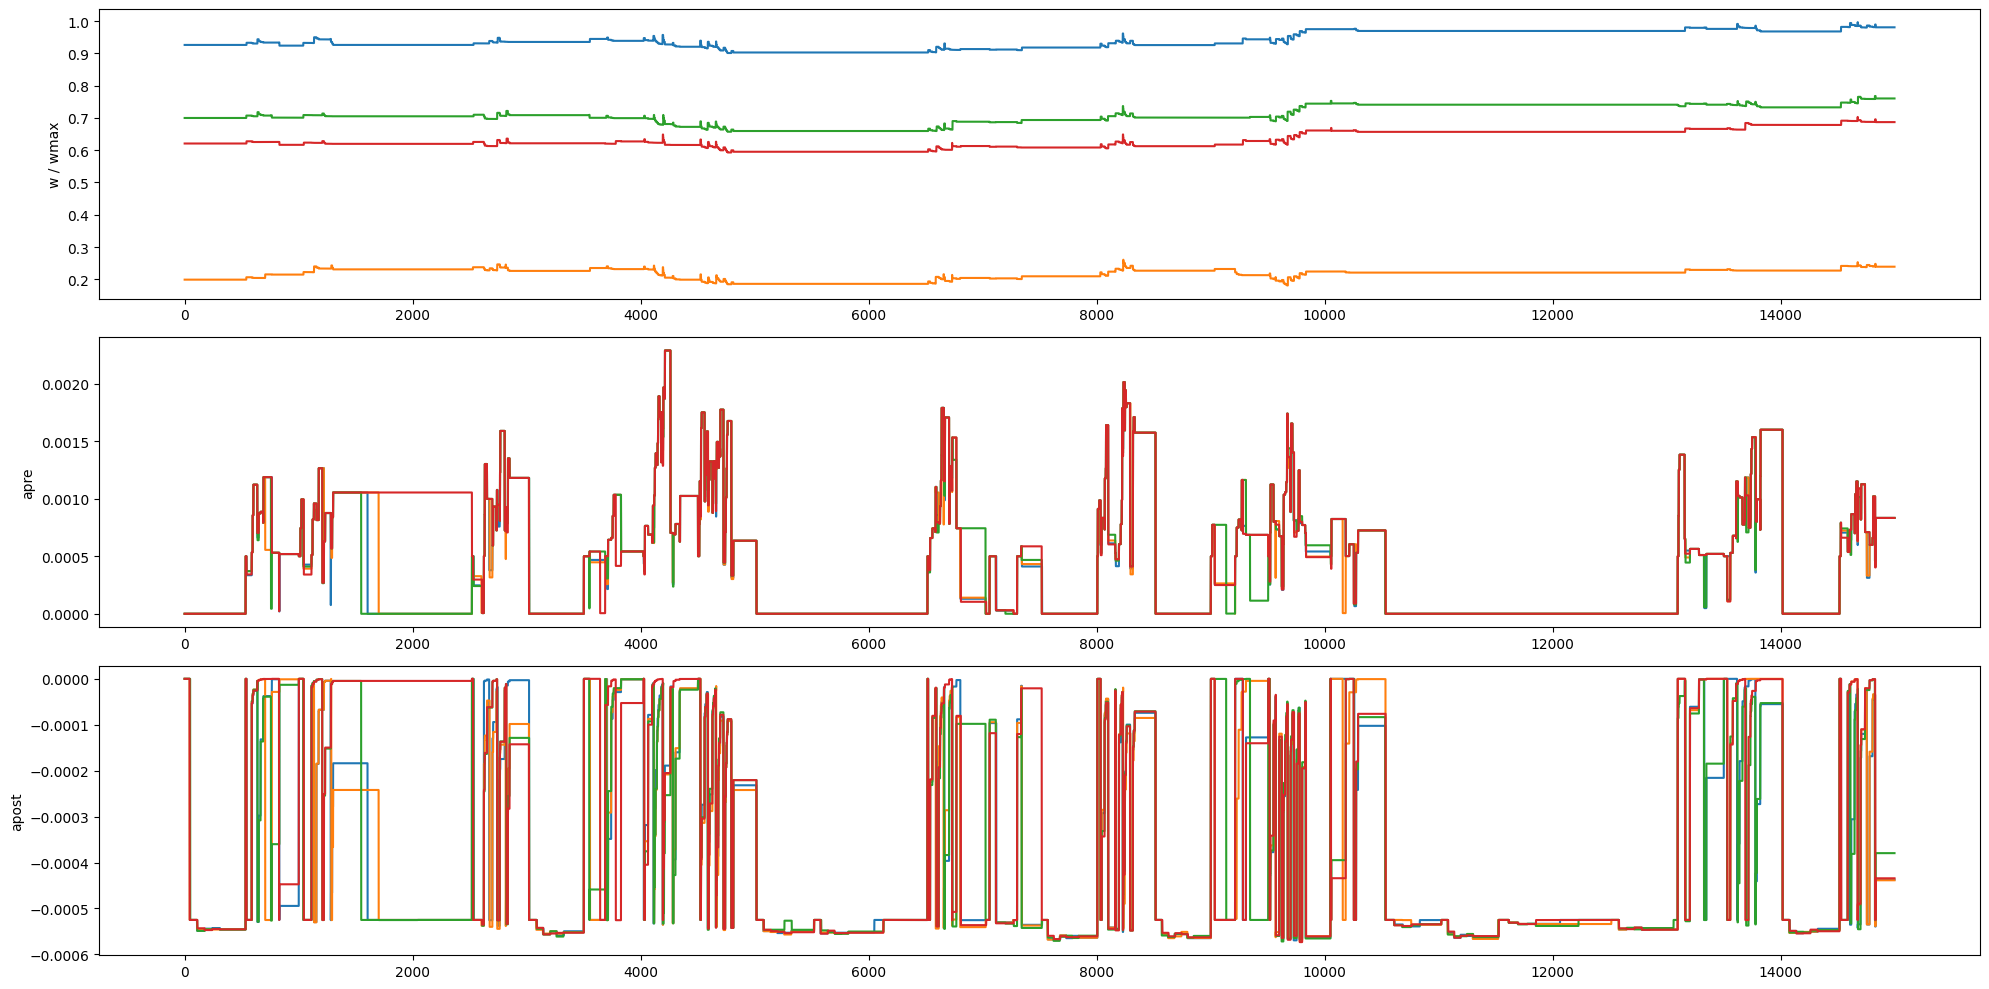

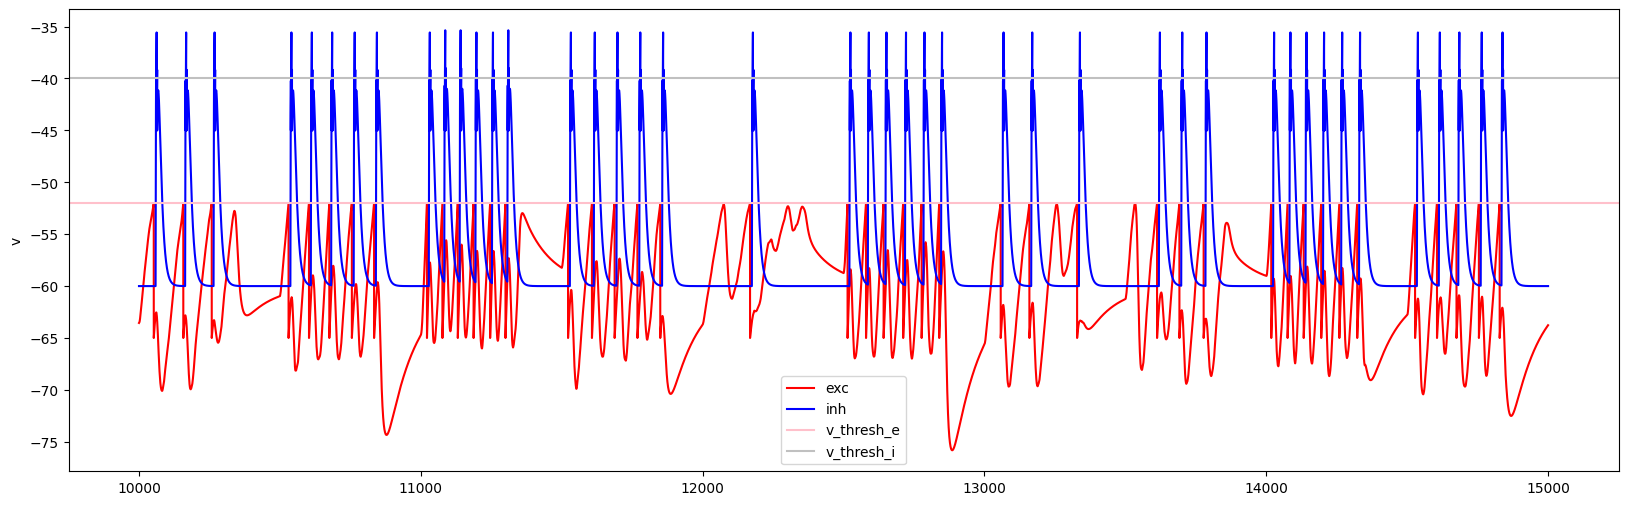

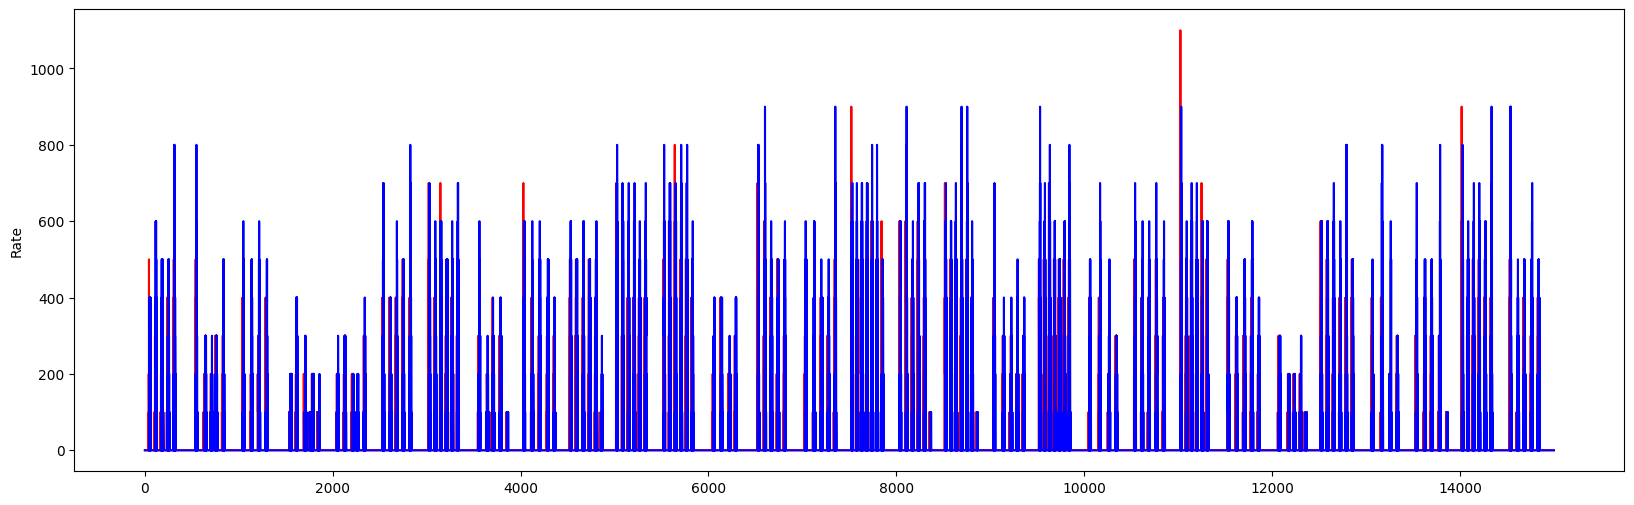

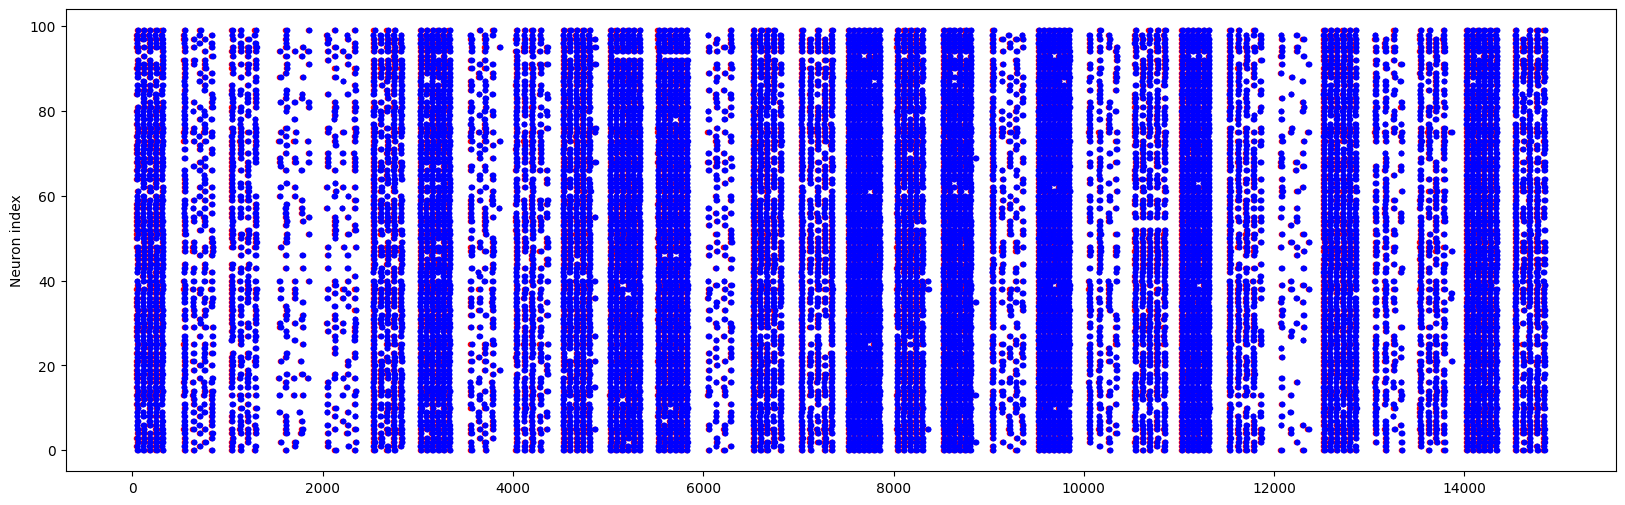

In [72]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();
    
def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=1)
    
    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])
    
test0()

#### STDP (Spike-Timing-Dependent Plasticity, 신경망의 학습 과정에서 시냅스 가중치의 조정)의 사용 여부를 기준으로 test1과 test2 구분

- **test1** : 먼저 STDP를 사용하여 네트워크를 "미세 조정"한 다음, 이후 과정에서는 고정된 네트워크 구조를 사용

In [76]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch import backends as backends

dev = "cuda"
if torch.cuda.is_available():
    dev = "cuda"
elif backends.mps.is_available():
    dev = "mps"
else:
    dev = "cpu"
print(dev)
device = torch.device(dev)

mps


In [77]:
def test1(train_items=5000, assign_items=1000, eval_items=1000):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
    model.train(X_train[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test1()

WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
 [py.warnings]
WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
 [py.warnings]
WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
 [py.warnings]
WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: Future

0.422
0.035
[[ 22  11   0   0   0   0   0   0  15   0]
 [  5  11   0   0   0   0   0   0   9   0]
 [240 296   0   0   0   0   0   0 238   0]
 [  0   1   0   0   0   0   0   0   2   0]
 [ 10   7   0   0   0   0   0   0  16   0]
 [  1   2   0   0   0   0   0   0   2   0]
 [ 15   1   0   0   0   0   0   0  14   0]
 [  4  23   0   0   0   0   0   0  17   0]
 [  7   0   0   0   0   0   0   0   2   0]
 [  0  26   0   0   0   0   0   0   3   0]]


- **test2** : STDP를 처음부터 비활성화한 상태로 시작합니다. 즉, SNN은 처음부터 고정된 구조를 가지고 훈련 데이터셋을 처리.

STDP를 사용하지 않음으로써, 네트워크는 학습 과정에서 가중치를 조정하지 않음

In [78]:
def test2(train_items=5000, assign_items=1000, eval_items=1000):
    '''
    Freeze STDP at start
    Feed train set to SNN and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
        
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test2()

WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
 [py.warnings]
WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
 [py.warnings]
WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
 [py.warnings]
WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: Future

0.392
0.023
[[  9   5   0   0   0   0   0   0   6   0]
 [ 14  12   0   0   0   0   0   0   4   0]
 [178 257   0   0   0   0   0   0 182   0]
 [  3  16   0   0   0   0   0   0   9   0]
 [ 21  33   0   0   0   0   0   0  37   0]
 [  5  26   0   0   0   0   0   0   2   0]
 [ 47   0   0   0   0   0   0   0  26   0]
 [ 22  18   0   0   0   0   0   0  48   0]
 [  5   0   0   0   0   0   0   0   2   0]
 [  0  11   0   0   0   0   0   0   2   0]]


### 추가적인 연구 논문 : Spiking Neural Network (SNN) with PyTorch: towards bridging the gap between deep learning and the human brain 

- https://guillaume-chevalier.com/spiking-neural-network-snn-with-pytorch-where-backpropagation-engenders-stdp-hebbian-learning/

- https://github.com/guillaume-chevalier/Spiking-Neural-Network-SNN-with-PyTorch-where-Backpropagation-engenders-STDP/blob/master/Spiking%20Neural%20Networks%20with%20PyTorch.ipynb

In [79]:
import os

import matplotlib.pyplot as plt

import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable

In [80]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))

def train_many_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
            
def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

In [81]:
batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 21640817.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 961928.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3127552.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6535344.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [82]:
# Use GPU whever possible!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [83]:
class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

#### Training a Spiking Neural Network (SNN)

In [84]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
train_many_epochs(spiking_model)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.391233 Accuracy: 10.10%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.879598 Accuracy: 11.00%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.261111 Accuracy: 55.90%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.747068 Accuracy: 74.60%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.616832 Accuracy: 77.40%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.441908 Accuracy: 87.50%


WARNING    /opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
 [py.warnings]



Test set: Average loss: 0.0004, Accuracy: 8867/10000 (88.67%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.385971 Accuracy: 88.60%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.407205 Accuracy: 88.20%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.358598 Accuracy: 88.00%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.387111 Accuracy: 88.10%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.375179 Accuracy: 88.00%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.322688 Accuracy: 90.50%

Test set: Average loss: 0.0003, Accuracy: 9047/10000 (90.47%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.322551 Accuracy: 90.50%
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.314720 Accuracy: 91.80%
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.285432 Accuracy: 91.80%
Train Epoch: 3 [30000/60000 (50%)] Loss: 0.326568 Accuracy: 89.90%
Train Epoch: 3 [40000/60000 (67%)] Loss: 0.342393 Accuracy: 89.70%
Train Epoch: 3 [50000/60000 (83%)] Loss: 0.349122 Accuracy: 88.90%

Test set: Average loss: 0.0003, Accuracy: 9071/10000 (90.71%)



#### Training a Feedforward Neural Network (for comparison)

In [85]:
non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.304812 Accuracy: 14.00%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.929256 Accuracy: 54.40%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.287512 Accuracy: 72.80%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.883133 Accuracy: 80.50%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.685327 Accuracy: 81.50%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.592536 Accuracy: 83.90%

Test set: Average loss: 0.0005, Accuracy: 8673/10000 (86.73%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.503104 Accuracy: 87.90%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.494132 Accuracy: 88.30%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.475908 Accuracy: 88.20%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.453505 Accuracy: 89.00%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.478915 Accuracy: 85.90%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.434696 Accuracy: 88.70%

Test set: Average loss: 0.0004, Accuracy: 8878/10000 (88.78%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.446376 Accuracy: 86.90%
Train Epoch: 3 [

#### Let's see how the neurons spiked

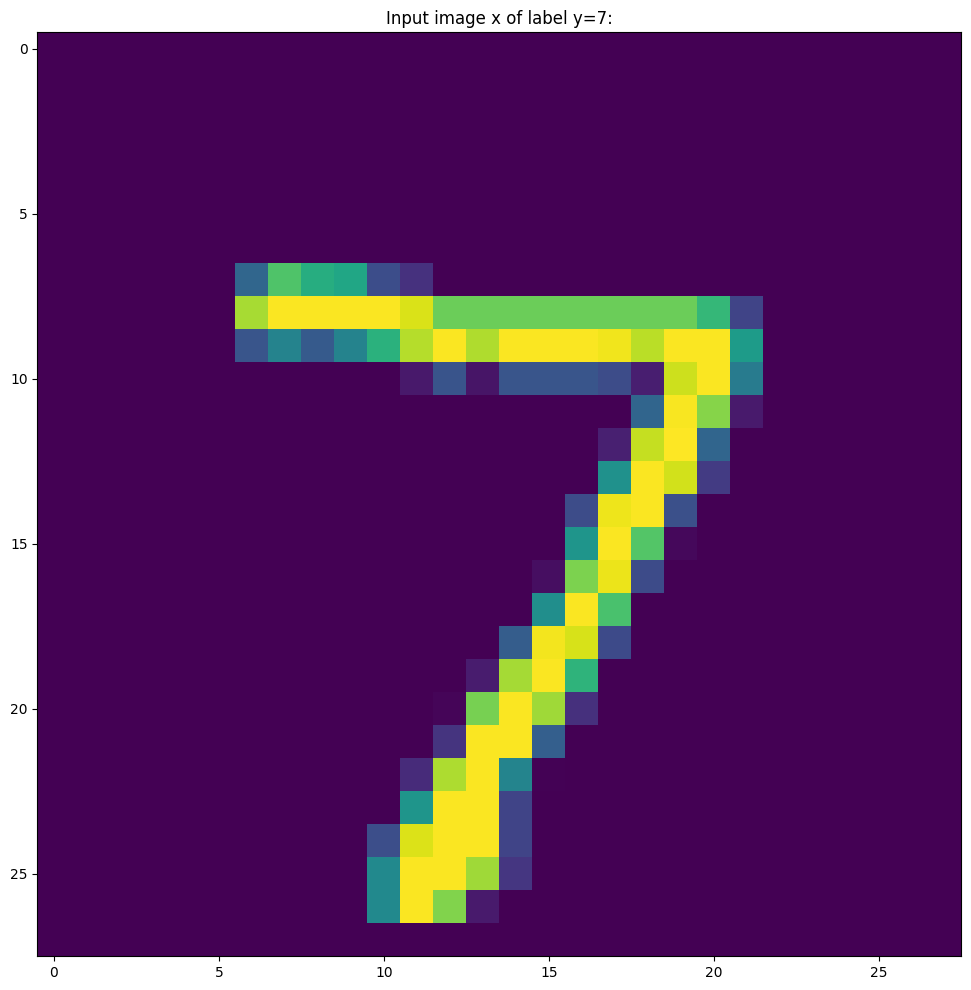

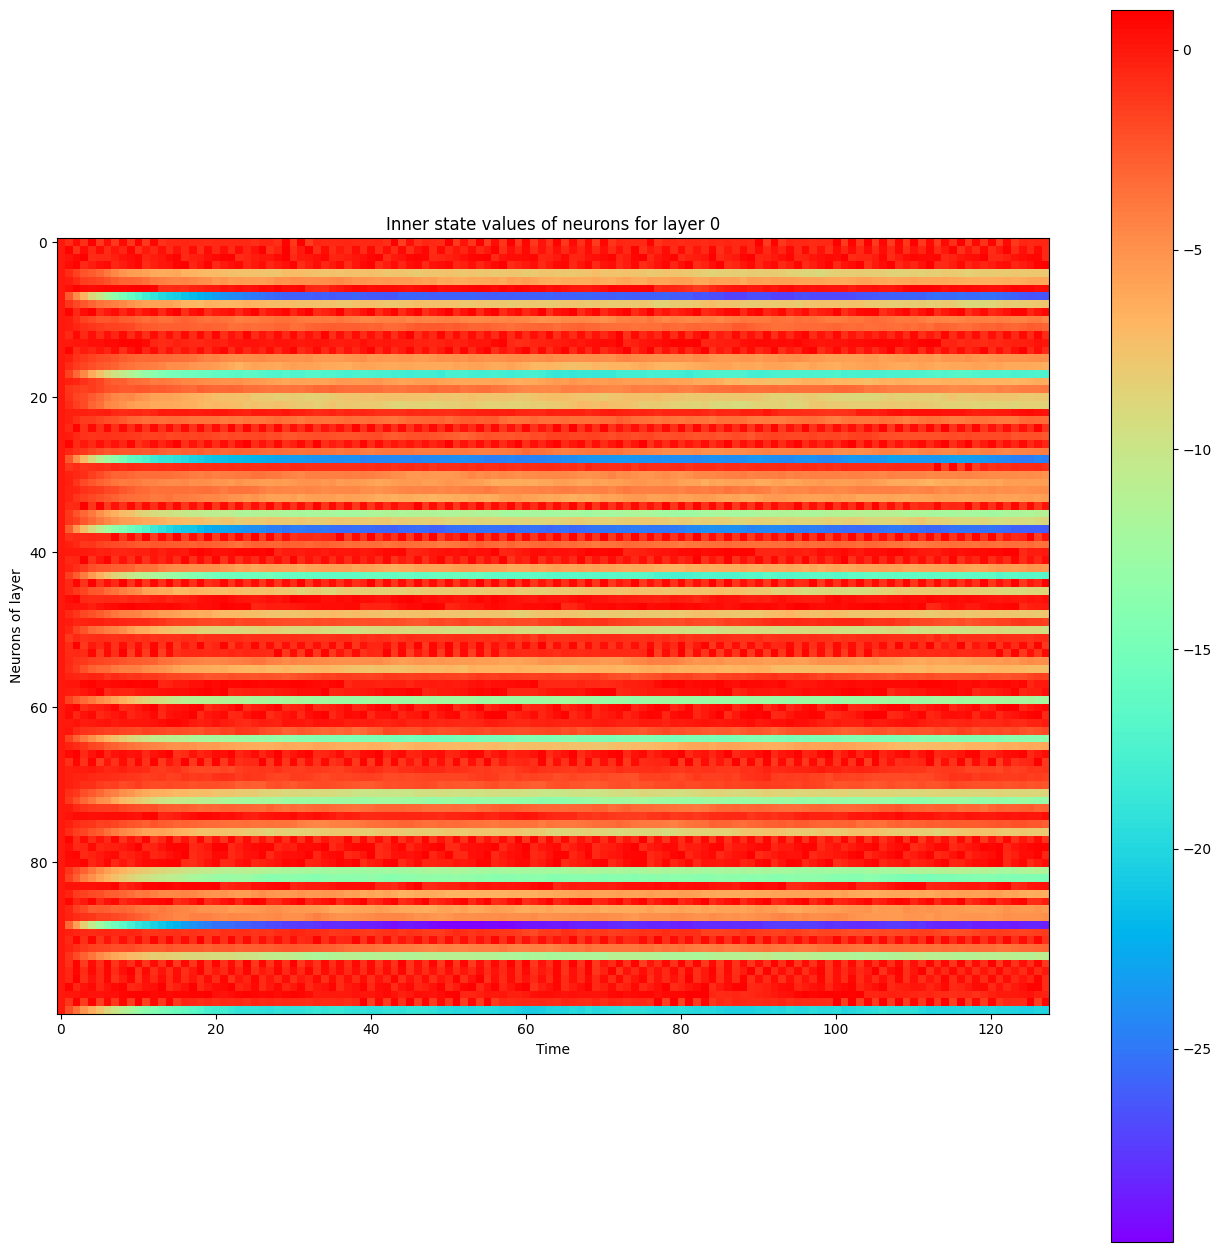

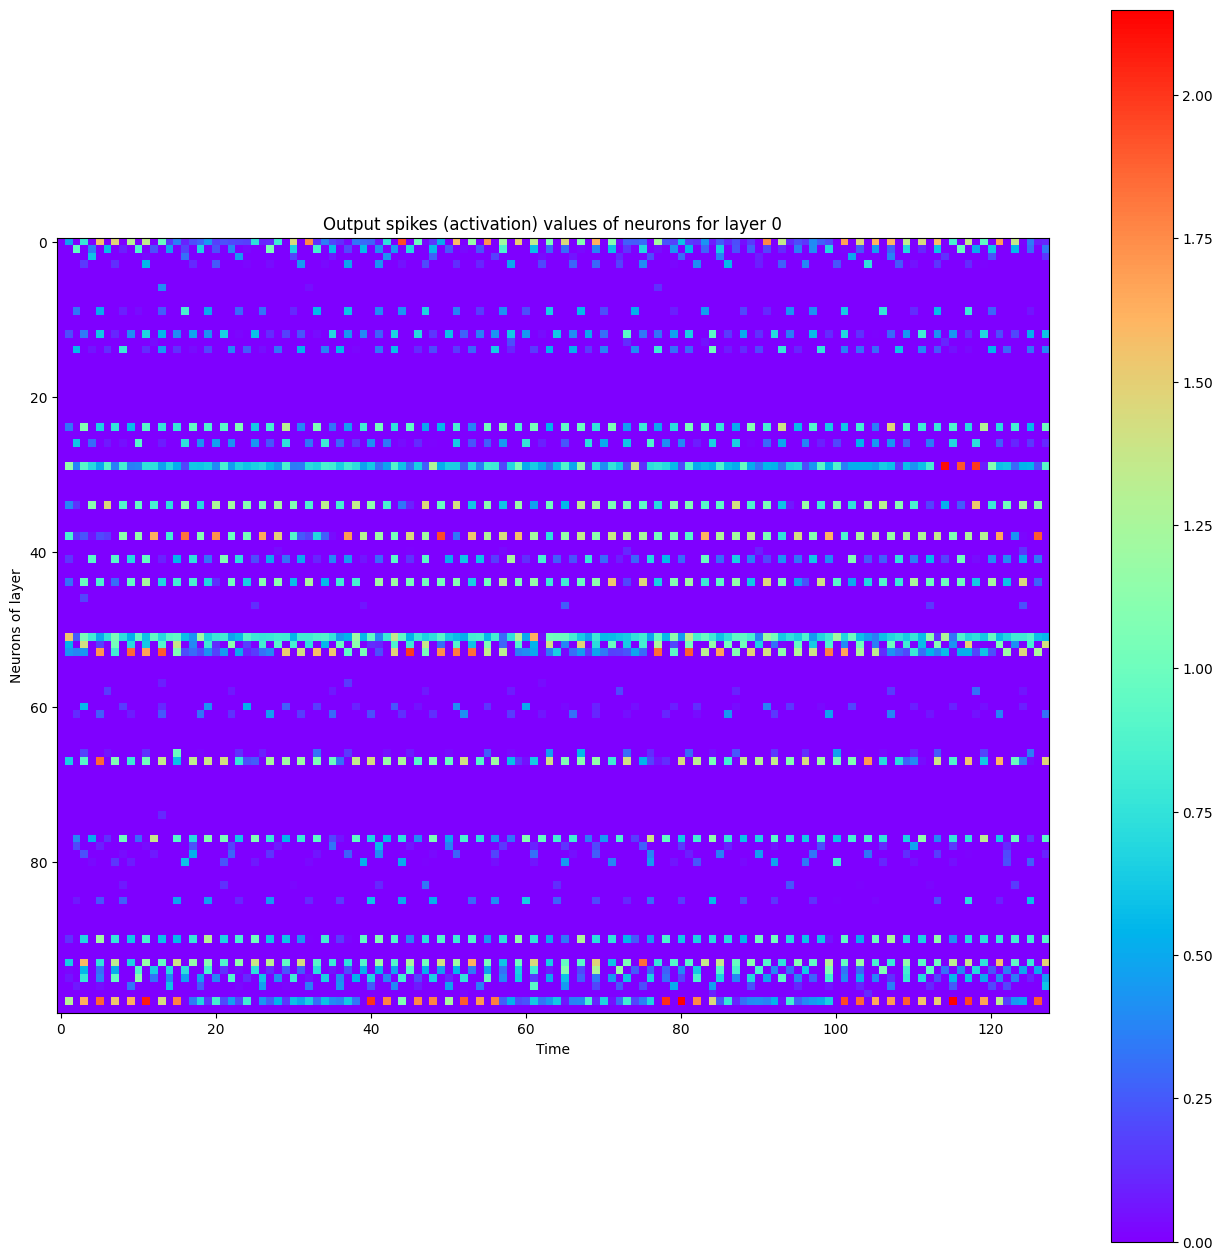

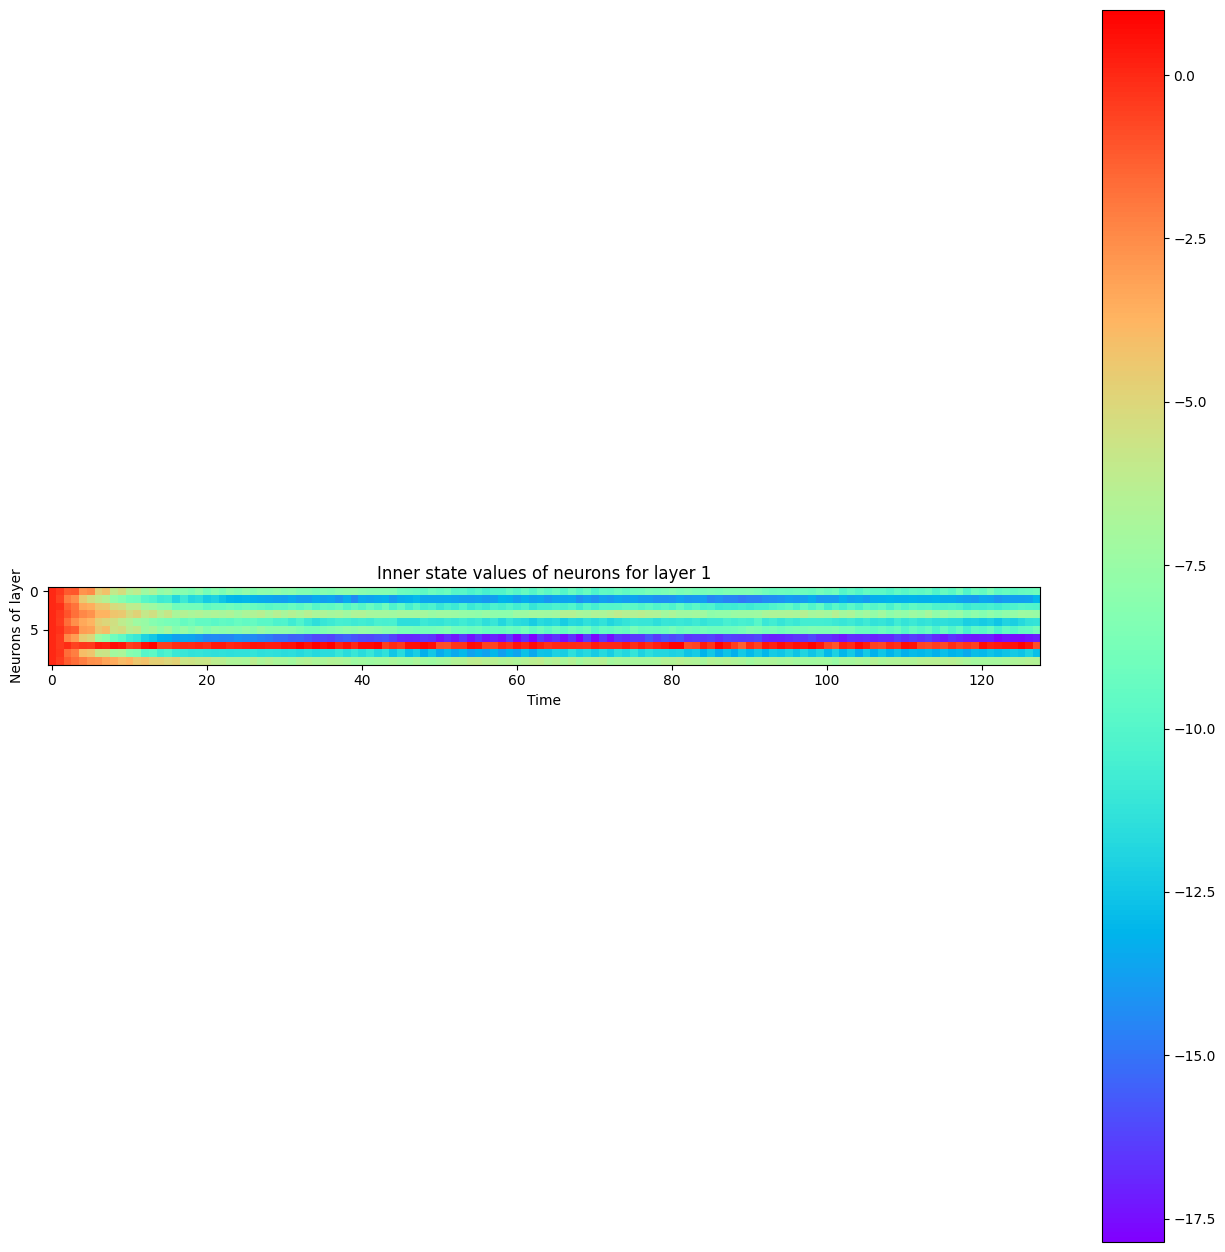

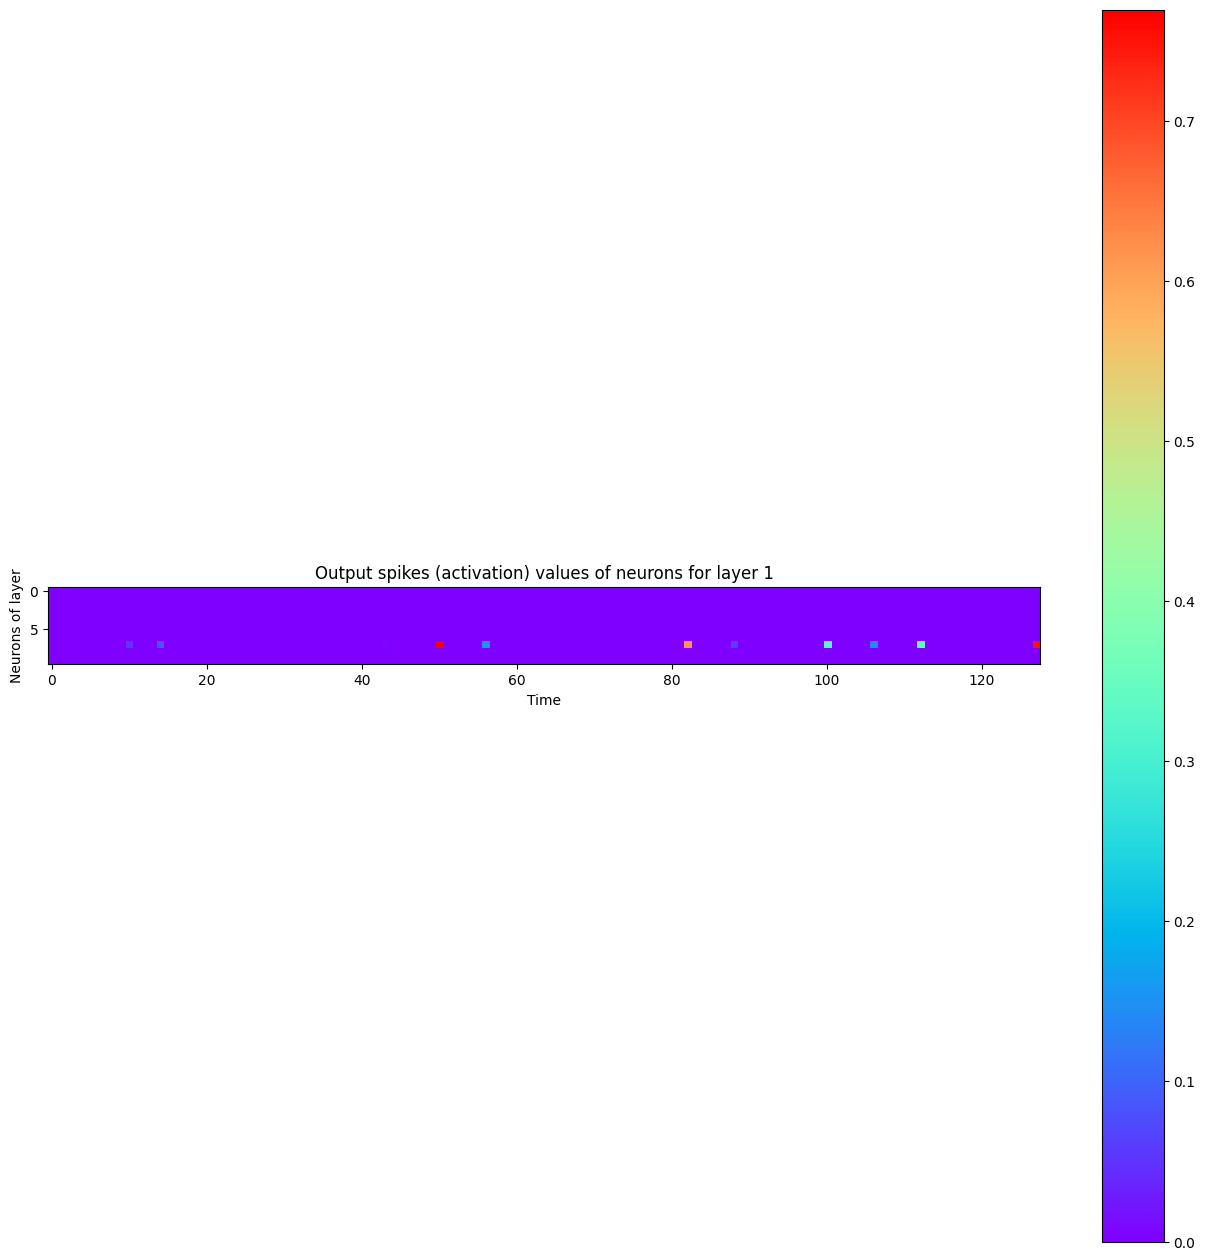

A hidden neuron that looks excited:


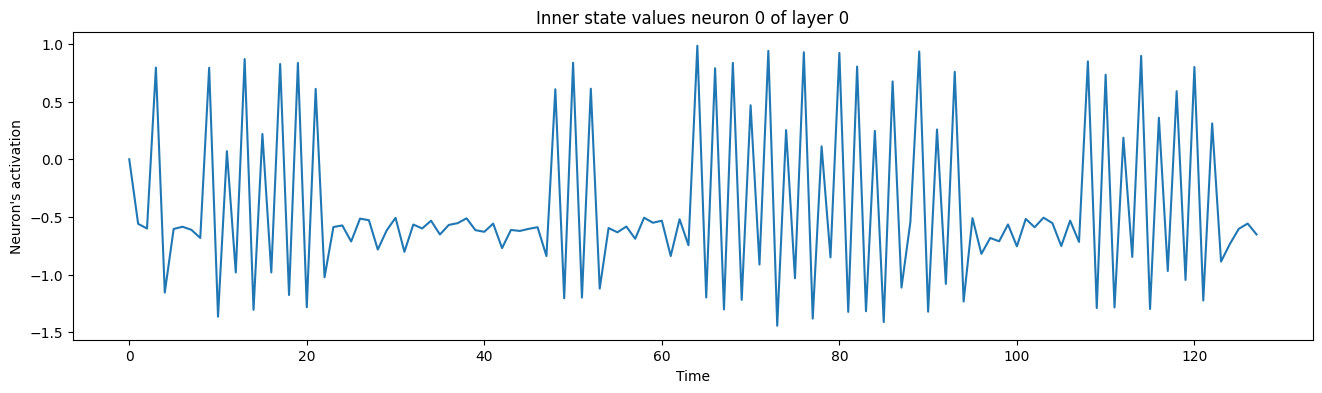

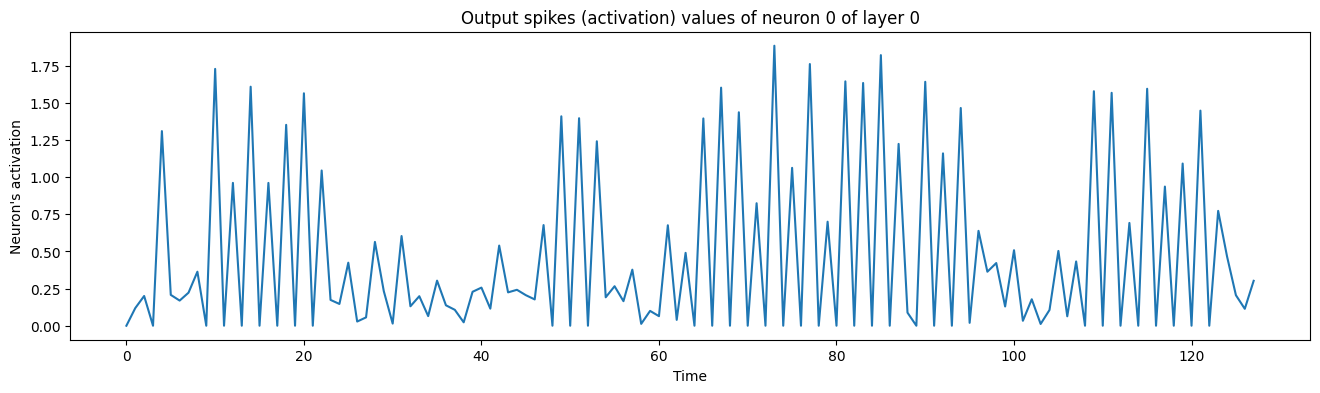

The output neuron of the label:


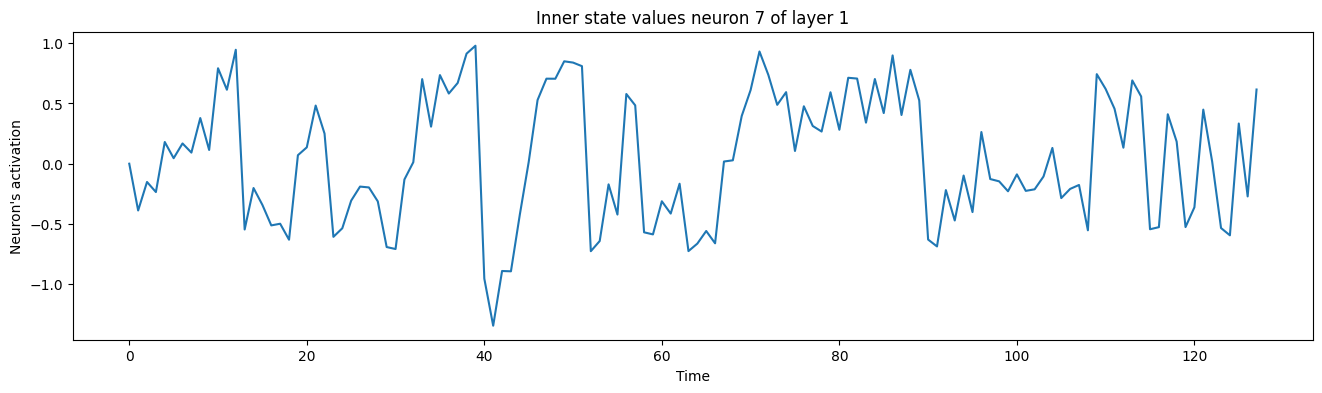

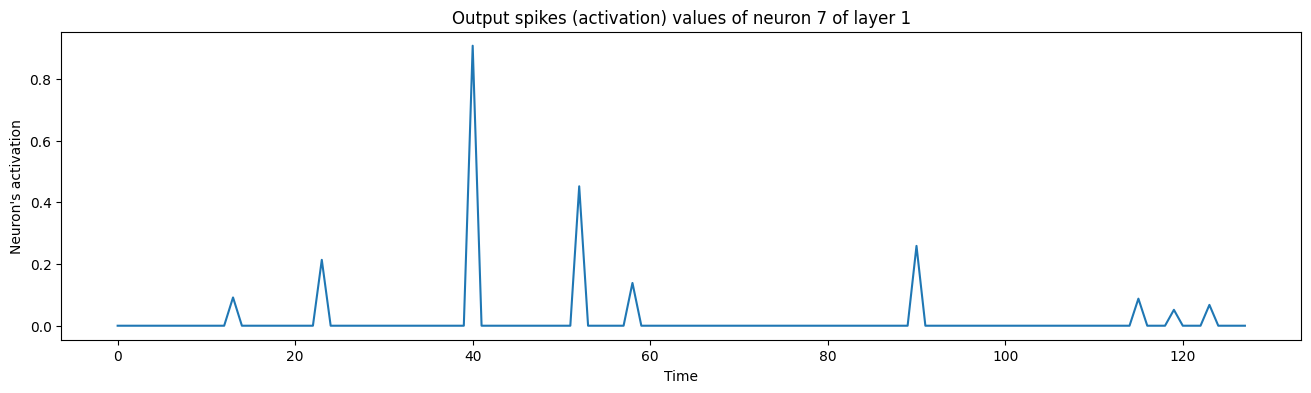

In [86]:
data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]]) 
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

### epoch 수를 증가시킴 (learning rate scheduler에 ReduceLROnPlateau를 사용)

In [94]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
    
def train_many_epochs(model, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    for epoch in range(1, num_epochs + 1):
        train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
        test_loss = test(model, device, test_set_loader)

        # 스케줄러 업데이트: 테스트 손실을 기준으로 학습률 조정
        scheduler.step(test_loss)
            
def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    
    # 테스트 손실 반환
    return test_loss

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

In [95]:
class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

#### Training a Spiking Neural Network (SNN)

In [96]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
train_many_epochs(spiking_model, 100)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.426512 Accuracy: 6.90%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.914307 Accuracy: 15.00%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.594141 Accuracy: 46.40%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.858048 Accuracy: 71.50%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.558308 Accuracy: 83.00%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.484128 Accuracy: 85.80%

Test set: Average loss: 0.0004, Accuracy: 8741/10000 (87.41%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.421208 Accuracy: 85.80%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.478828 Accuracy: 84.90%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.431909 Accuracy: 85.80%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.404716 Accuracy: 88.20%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.390122 Accuracy: 87.50%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.397631 Accuracy: 87.40%

Test set: Average loss: 0.0003, Accuracy: 9084/10000 (90.84%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.300538 Accuracy: 91.60%
Train Epoch: 3 [1

#### Training a Feedforward Neural Network (for comparison)

In [97]:
non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model, 100)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.307227 Accuracy: 10.90%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.905201 Accuracy: 57.20%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.294467 Accuracy: 74.80%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.895425 Accuracy: 80.60%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.677804 Accuracy: 84.00%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.589439 Accuracy: 84.20%

Test set: Average loss: 0.0005, Accuracy: 8744/10000 (87.44%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.511182 Accuracy: 87.90%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.454494 Accuracy: 88.80%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.442757 Accuracy: 88.40%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.451260 Accuracy: 87.30%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.382556 Accuracy: 89.10%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.391707 Accuracy: 89.10%

Test set: Average loss: 0.0004, Accuracy: 8945/10000 (89.45%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.379585 Accuracy: 90.30%
Train Epoch: 3 [

#### Let's see how the neurons spiked

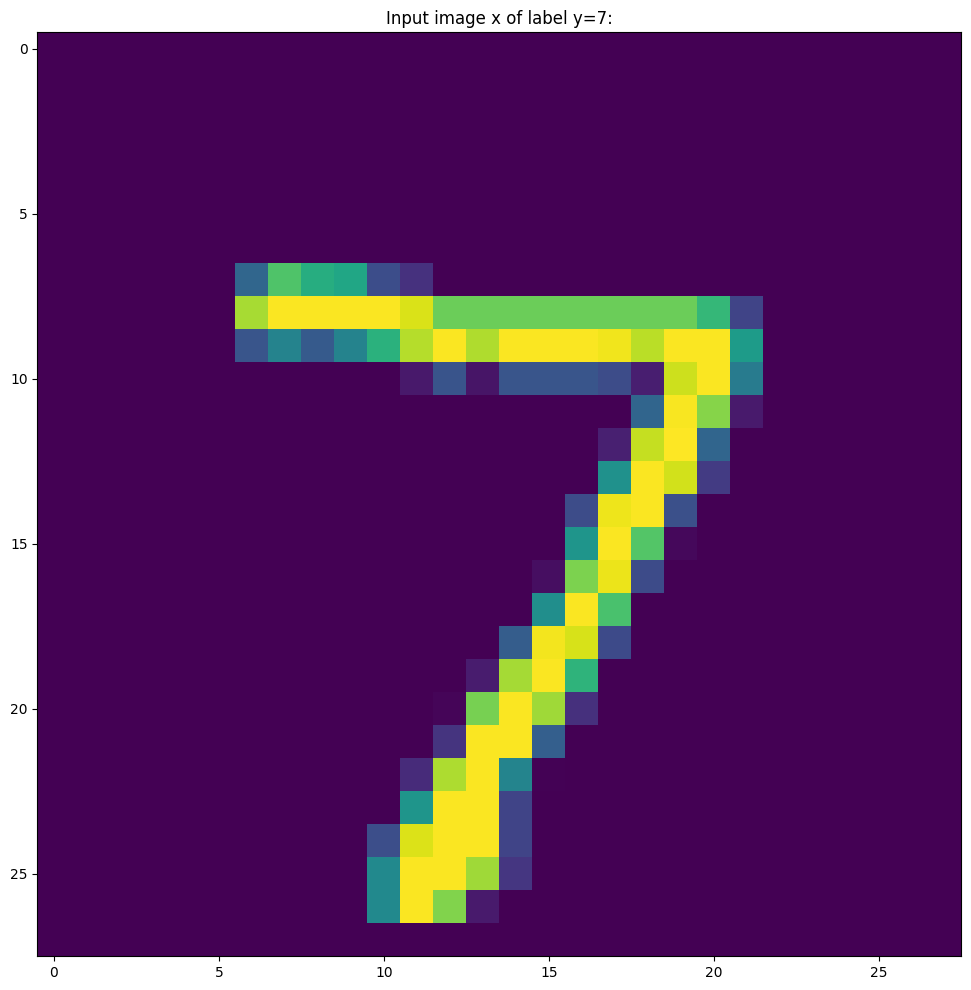

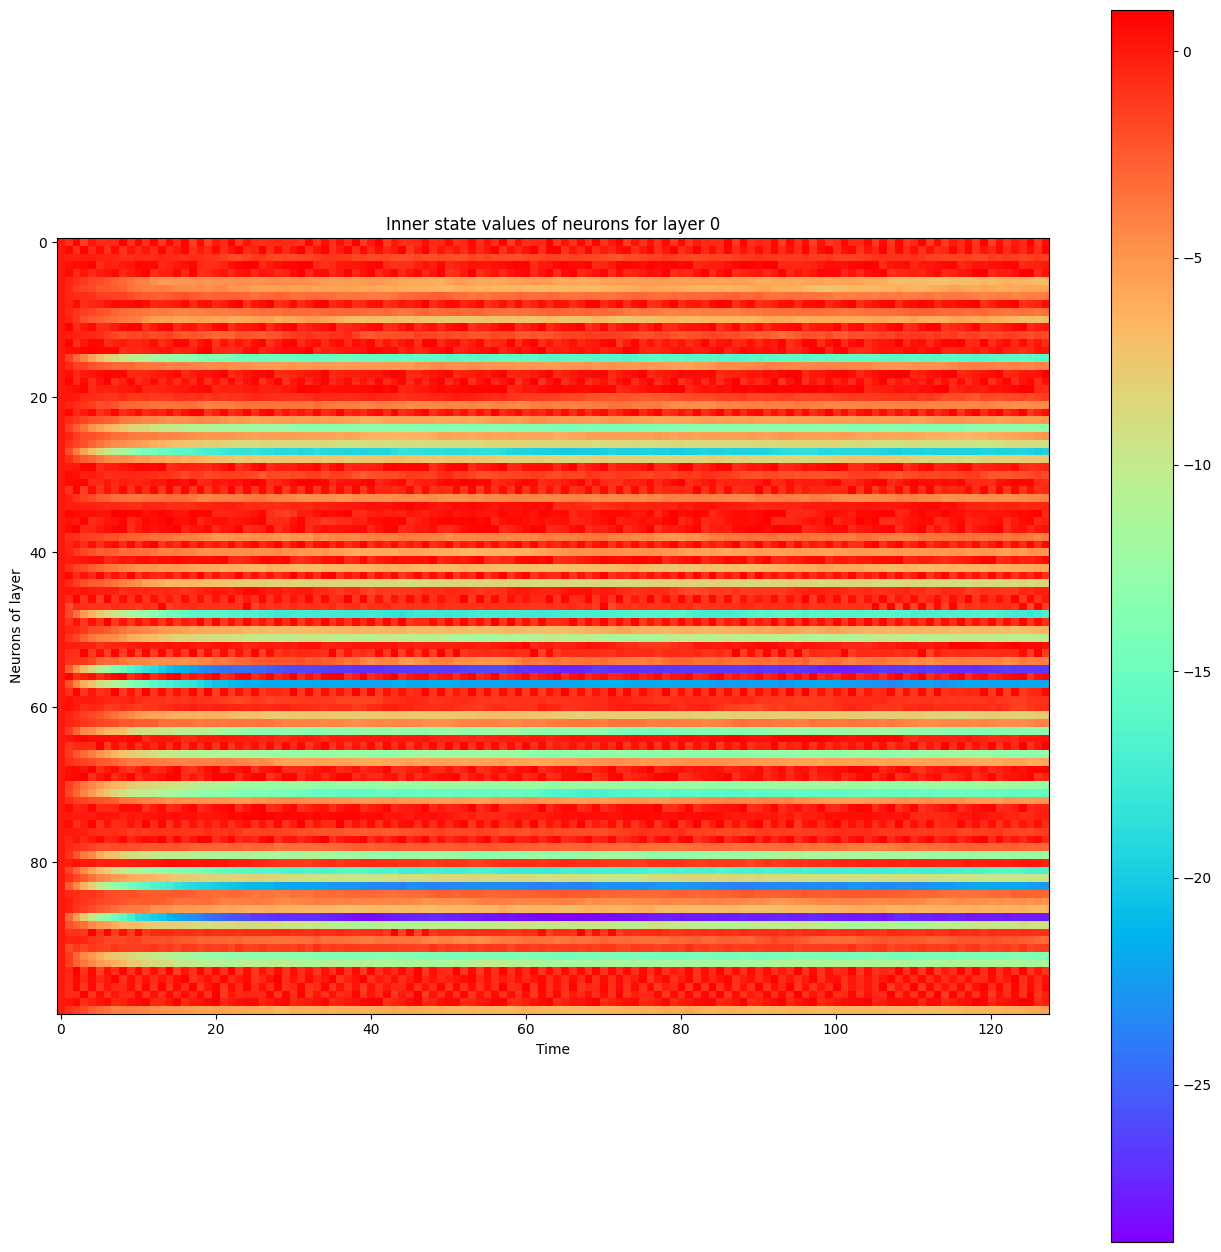

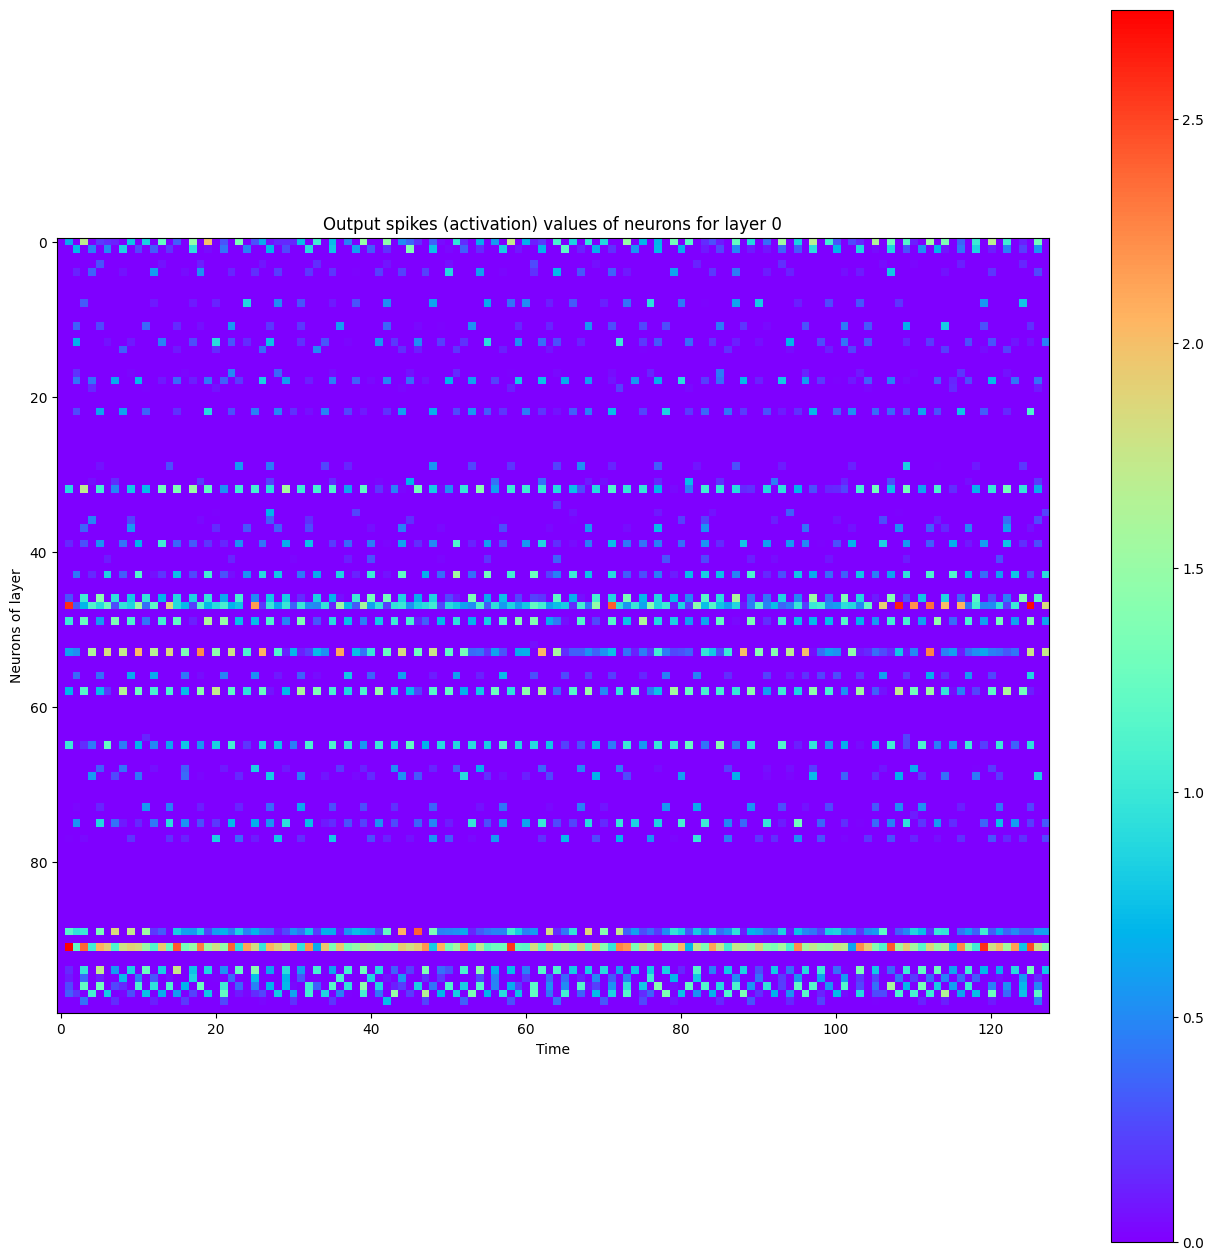

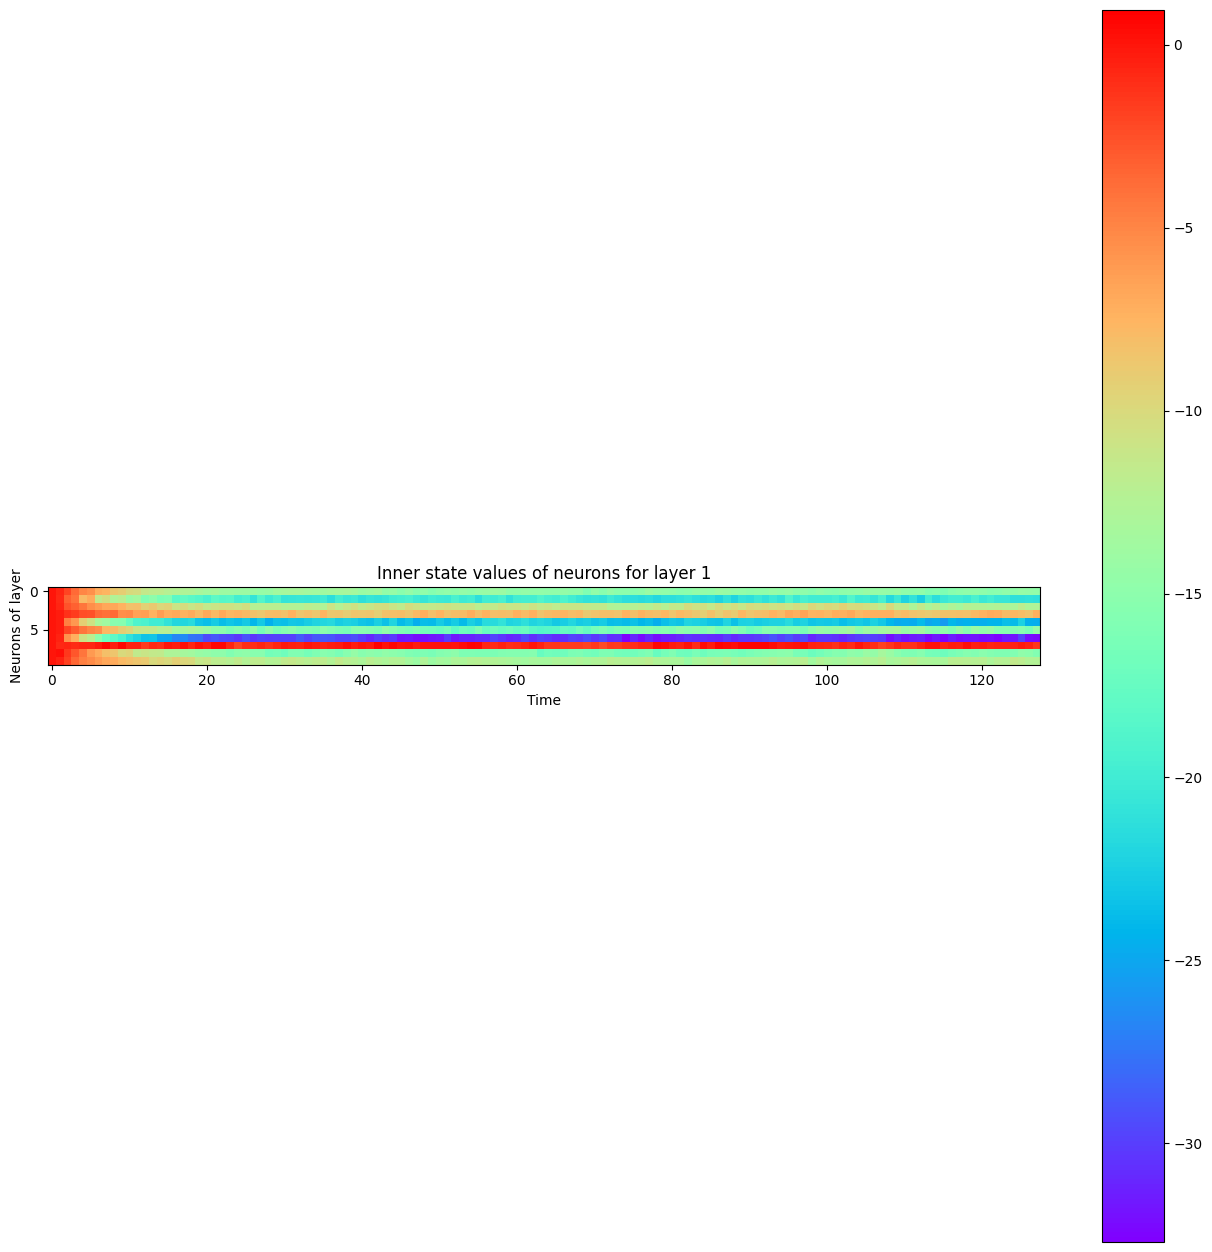

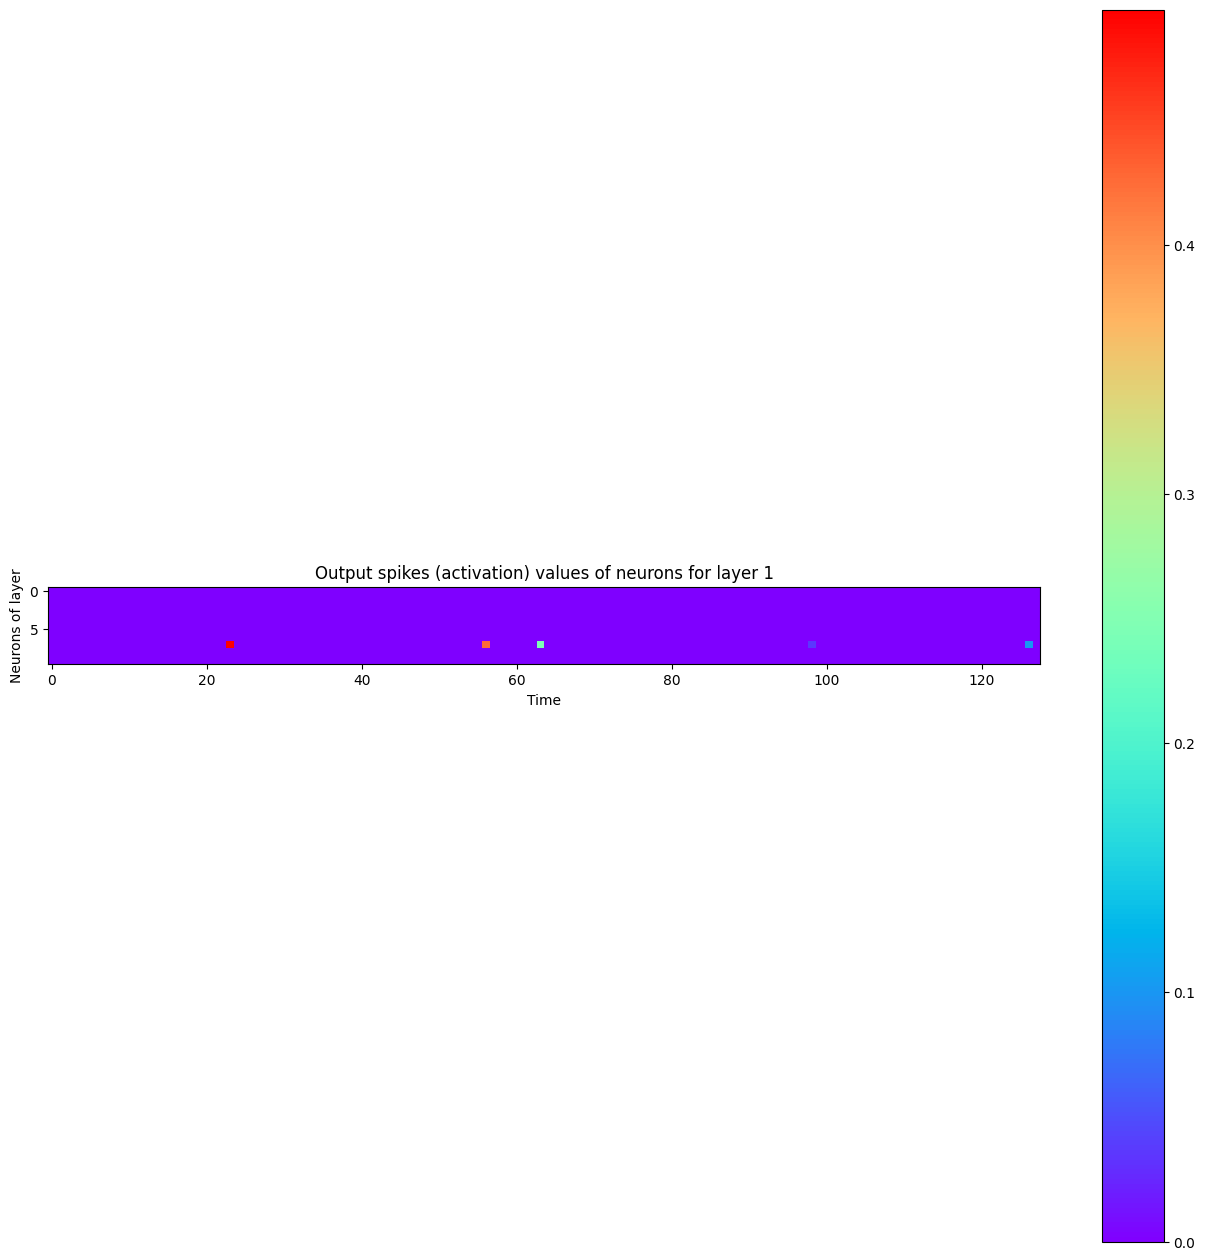

A hidden neuron that looks excited:


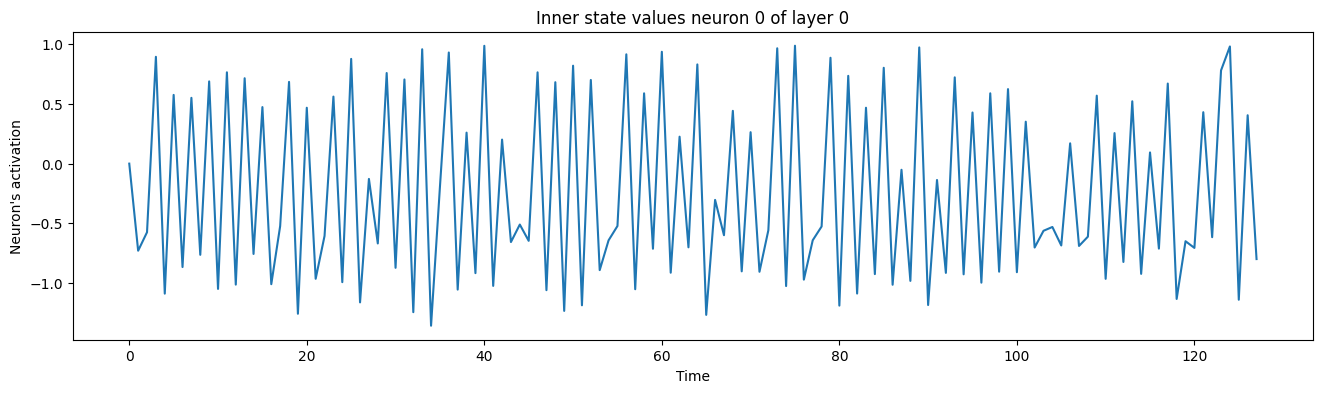

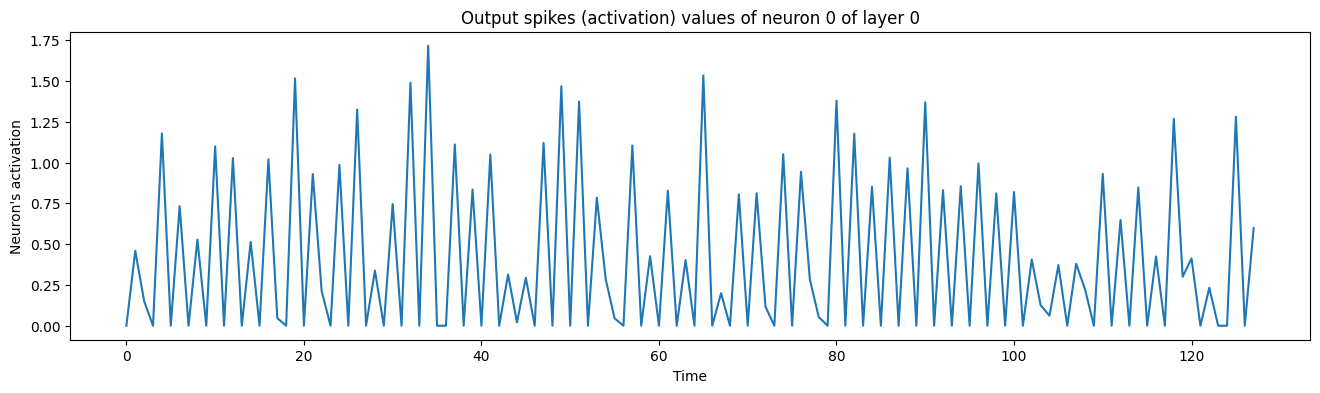

The output neuron of the label:


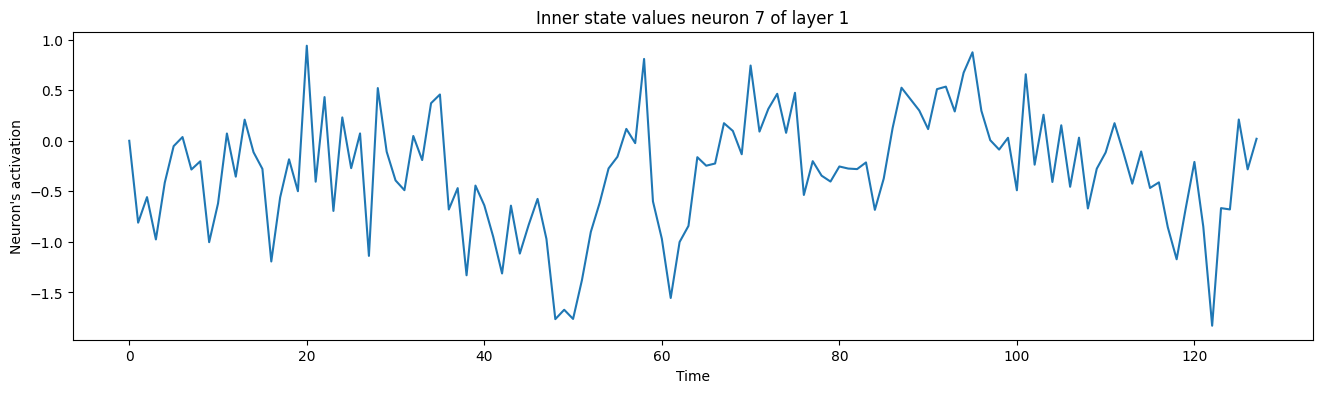

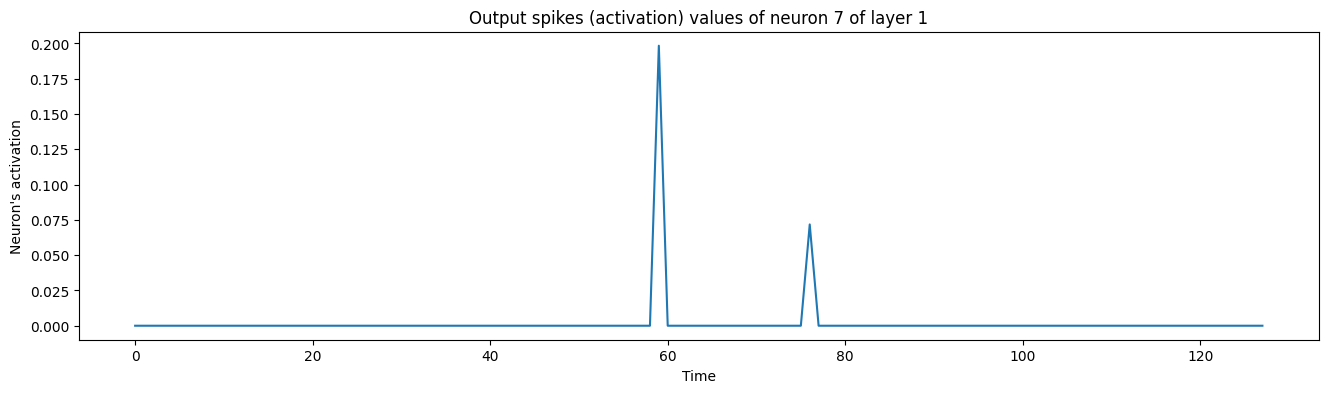

In [98]:
data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]]) 
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)